# SPI-based drought characteristics
--------------------------------------------------

> **Notes**
> This notebook required input SPI file in netcdf format computed by the `climate_indices` package available from https://github.com/monocongo/climate_indices.

The drought characteristics originally following the method proposed by Yevjevich in 1967 [^1] and has been employed to recognize the feature of droughts. The paper from Le, et al in 2019 [^2] provide better explanation about it: duration, severity, intensity, and interarrival.

![run_theory](https://datapartnership.org/morocco-economic-monitor/_images/runtheory.png)

Drought characteristics at all grid were identified using calculated monthly SPI for the total period of 43 years (181–2023). Drought is defined as the period in which SPI is continuously below a critical threshold (-1.2), respectively. 

For each category, we identified and analysed the following four main drought characteristics: events (E), duration (D), inter-arrival time (T), magnitude (M), and severity (S = M/D).

* Event: Month in which the SPEI is less than a threshold.
* Duration D: the number of consecutive months in which the SPEI is below the threshold.
* Inter-arrival T: the duration (month) between the initiation time of two successive drought events (regardless of the length) in the same drought category. It includes the drought and subsequent non-drought periods. Therefore, T characterizes the timing variability of drought events.
* Magnitude M: the absolute cumulative SPEI value during drought events. Unitless. (On Le's paper, Magnitude are called as Severity)
* Severity S: the number came from magnitude divided by duration to get level of severity. Unitless. (According to attached picture, many papers also mixed up between last two variables, magnitude and severity and also intensity)

[^1]: https://www.engr.colostate.edu/ce/facultystaff/yevjevich/papers/HydrologyPapers_n23_1967.pdf </br>
[^2]: https://www.researchgate.net/publication/333171255_Space-time_variability_of_drought_over_Vietnam </br>

## Drought Event

Here's what this script does to calculate the drought event with threshold `SPI <-1.2`:

* It opens your SPI dataset using `xr.open_dataset`.
* It calculates the drought event by checking if the SPI value is less than `-1.2`. If it is, it assigns a value of `1`; otherwise, it assigns a value of `0`. The calculation is performed using `xr.where`.
* Finally, it saves the dataset, which now includes the new drought event variable, to a new netCDF file using `to_netcdf`.

This script assumes that the SPI variable is named `spi_gamma_x_month` in the netCDF file. Please modify the script as necessary based on your specific data.


In [13]:
import xarray as xr
import numpy as np

# Open the SPI dataset
ds_drought = xr.open_dataset('../SPI/mar/05_spi_output_netcdf/mar_cli_chirps_spi_gamma_6_month.nc')

# Define a drought event as an SPI value less than -1.2
ds_drought['drought_event'] = xr.where(ds_drought['spi_gamma_6_month'] < -1.2, 1, ds_drought['spi_gamma_6_month'] * 0)

# Transpose to the original dimensions
ds_drought = ds_drought.transpose('time', 'lat', 'lon')

# Save the new drought event variable to a new netCDF file
ds_drought.to_netcdf('../SPI/mar/07_drought_variable/mar_cli_spi06_drought_event.nc')

print('Completed!')


Completed!


## Drought Inter-arrival Time

This script performs the following steps to calculate the drought inter-arrival time:

1. The script opens your drought event dataset using `xr.open_dataset`.

2. It extracts the 'drought_event' variable from your dataset.

3. The script then defines a function to compute inter-arrival times for a time series. This function works as follows:

   - It identifies where drought events occur in the time series by finding where the time series value equals 1, using the `np.where` function.
   
   - It calculates the differences between successive events using the `np.diff` function, which gives the inter-arrival times.
   
   - It creates a new time series for inter-arrival times that is the same shape as the input and is initially filled with NaN values, using the `np.full_like` function.

   - The computed inter-arrival times are then assigned to the indices following the start of each event in the new time series. The first event is skipped because there's no previous event to measure an inter-arrival time from.

4. This function is applied to each time series in the 'drought_event' variable, grouping by latitude and longitude so that each time series is processed independently. The `groupby` method is used to achieve this. This results in a new DataArray of inter-arrival times.

5. This new DataArray is added to the original Dataset as a new variable 'interarrival_times'.

6. The updated Dataset, which now includes the new 'interarrival_times' variable, is then saved to a new netCDF file using the `to_netcdf` method.

7. Finally, it closes the original dataset file to free up system resources.

This script assumes that the 'drought_event' variable is stored in the netCDF file and each grid cell's time series is processed independently from the others. Please adjust the script as necessary based on your specific data.

In [14]:
import xarray as xr
import numpy as np
import pandas as pd

# Open the SPI dataset
ds_drought = xr.open_dataset('../SPI/mar/07_drought_variable/mar_cli_spi06_drought_event.nc')

# Transpose the dataset to respect original dimensions
ds_drought = ds_drought.transpose('time', 'lat', 'lon')

# Convert to a multi-indexed DataFrame
df_drought = ds_drought.to_dataframe()

# Reset the index to put 'lat' and 'lon' into columns
df_drought.reset_index(inplace=True)

# Handle missing values: if drought_event is NaN, fill with previous value
df_drought['drought_event'] = df_drought.groupby(['lat', 'lon'])['drought_event'].fillna(method='ffill')

# Get the drought_event column
drought_events = df_drought['drought_event']

# Function to compute interarrival times for a time series
def compute_interarrival_times(time_series):
    # For the first date, use the value from the drought event
    interarrival_time_series = pd.Series(np.full_like(time_series, np.nan), index=time_series.index)
    interarrival_time_series.iloc[0] = time_series.iloc[0]
    
    # Get the indices where time_series represents a drought event (where time_series is 1)
    event_indices = np.where(time_series == 1)[0]

    # Calculate the differences between successive events
    interarrival_times = np.diff(event_indices)

    # Assign the computed interarrival times to the indices following the start of each event
    # Skip the first event (because there's no previous event to measure an interarrival time from)
    interarrival_time_series.iloc[event_indices[1:]] = interarrival_times

    return interarrival_time_series

# Apply the function to each ('lat', 'lon') group
df_drought['interarrival_times'] = df_drought.groupby(['lat', 'lon'])['drought_event'].transform(compute_interarrival_times)

# Convert the DataFrame back to an xarray Dataset
ds_drought = df_drought.set_index(['time', 'lat', 'lon']).to_xarray()

# Save the new drought interarrival times variable to a new netCDF file
ds_drought.to_netcdf('../SPI/mar/07_drought_variable/mar_cli_spi06_interarrival_times.nc')

# Close the original file
ds_drought.close()

print('Completed!')


Completed!


## Drought Magnitude

Here's what the script does to calculate the drought magnitude:

1. Opens your drought event dataset and the SPI data using `xr.open_dataset`.

2. Creates a new variable 'drought_magnitude' by copying the values from the 'drought_event' variable in your dataset.

3. Iterates through the time points in your dataset, starting from the second time point. For each time point, the script performs the following operations:

   - Checks if a drought event is occurring at that time point by extracting the 'drought_event' value using the `isel` method.
   
   - Retrieves the SPI value at that time point using the `isel` method.
   
   - Retrieves the drought magnitude value at the previous time point using the `isel` method.
   
   - Calculates the drought magnitude at the current time point. If a drought event is happening (i.e., drought_event is True), the drought magnitude is calculated as the absolute value of the SPI at that time point plus the drought magnitude at the previous time point. If no drought event is occurring, the existing value for drought magnitude at that time point (originally copied from 'drought_event') is retained. The `where` method is used to apply this conditional calculation.
   
4. Saves the dataset, which now includes the new 'drought_magnitude' variable, to a new netCDF file using the `to_netcdf` method.

5. Closes the original dataset file to free up system resources.

This script assumes that the 'drought_event' variable and the SPI data ('spi_gamma_12_month') are stored in the same netCDF file. Please adjust the script as necessary based on your specific data.

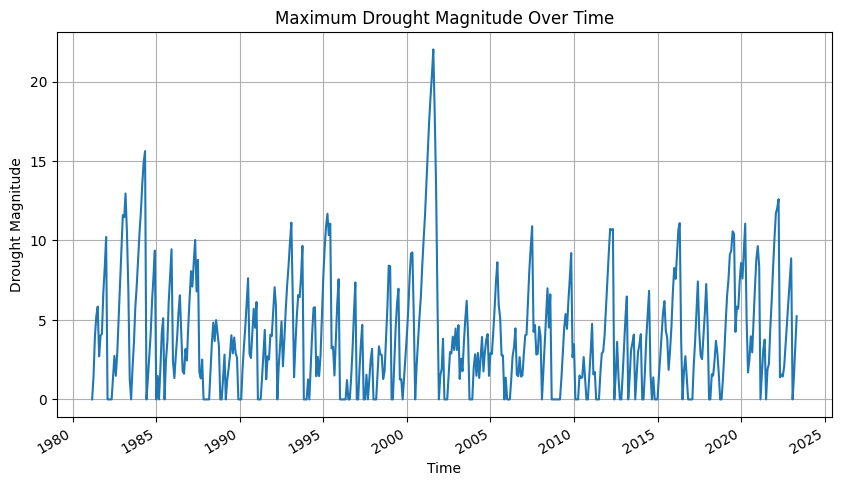

Completed!


In [15]:
import xarray as xr
import numpy as np
import os

# Open the drought event and spi data
ds_drought = xr.open_dataset('../SPI/mar/07_drought_variable/mar_cli_spi06_interarrival_times.nc')

# Transpose the dataset to respect original dimensions
ds_drought = ds_drought.transpose('time', 'lat', 'lon')

# Preallocate an empty array for drought_magnitude and set all to NaN
drought_magnitude_arr = np.empty_like(ds_drought['drought_event'].values, dtype=float)
drought_magnitude_arr[:] = np.nan

# Find the first time step where not all spi_gamma_3_month values are NaN
start_time = next(i for i in range(len(ds_drought.time)) if not np.isnan(ds_drought['spi_gamma_6_month'].isel(time=i).values).all())

# Start from the determined time step
for i in range(start_time, len(ds_drought.time)):
    # For each point, check if it's a drought event
    drought_event = ds_drought['drought_event'].isel(time=i).values
    spi_value = ds_drought['spi_gamma_6_month'].isel(time=i).values
    prev_drought_magnitude = drought_magnitude_arr[i-1]

    # Calculate drought magnitude based on your conditions
    drought_magnitude_arr[i] = np.where(drought_event, abs(spi_value) + prev_drought_magnitude, 0)

# Assign the calculated values to the drought_magnitude in the dataset
ds_drought['drought_magnitude'] = (('time', 'lat', 'lon'), drought_magnitude_arr)

# Save the new drought magnitude variable to a new netCDF file
ds_drought.to_netcdf('../SPI/mar/07_drought_variable/mar_cli_spi06_drought_magnitude.nc')

import matplotlib.pyplot as plt
# Plot maximum drought magnitude at each time step
plt.figure(figsize=(10, 5))
ds_drought['drought_magnitude'].max(dim=['lat', 'lon']).plot()
plt.title('Maximum Drought Magnitude Over Time')
plt.xlabel('Time')
plt.ylabel('Drought Magnitude')
plt.grid(True)
plt.show()

# Close the original file
ds_drought.close()

print('Completed!')


## Drought Duration

Here's what the updated script does to calculate the drought duration:

1. Opens your drought event dataset using `xr.open_dataset`.

2. Creates a new variable 'drought_duration' filled with NaN (Not a Number) values but of the same shape as the 'drought_event' variable in your dataset using `xr.full_like`.

3. For the first "time" data, it checks if 'drought_event' is finite (not NaN) and assigns the 'drought_event' value to 'drought_duration' if it is finite. The `np.where` function is used for this conditional assignment.

4. Then it starts iterating over the time points in your dataset, beginning from the second time point. For each time point, the script performs the following operations:

   - Checks if a drought event is occurring at that time point by extracting the 'drought_event' value using the `isel` method.
   
   - Retrieves the drought duration value at the previous time point using the `isel` method.
   
   - Computes a mask for finite values in 'drought_event' using `np.isfinite`.
   
   - If a drought event is happening (i.e., 'drought_event' is 1), the drought duration at the current time point is calculated as the drought duration at the previous time point plus one. If no drought event is occurring, the drought duration at the current time point is set to 0. If 'drought_event' is NaN, 'drought_duration' is kept as NaN. The `np.where` function is used for this triple conditional calculation.

5. Saves the dataset, which now includes the new 'drought_duration' variable, to a new netCDF file using the `to_netcdf` method.

6. Finally, it closes the original dataset file to free up system resources.

This script assumes that the 'drought_event' variable is stored in the netCDF file. Please adjust the script as necessary based on your specific data.

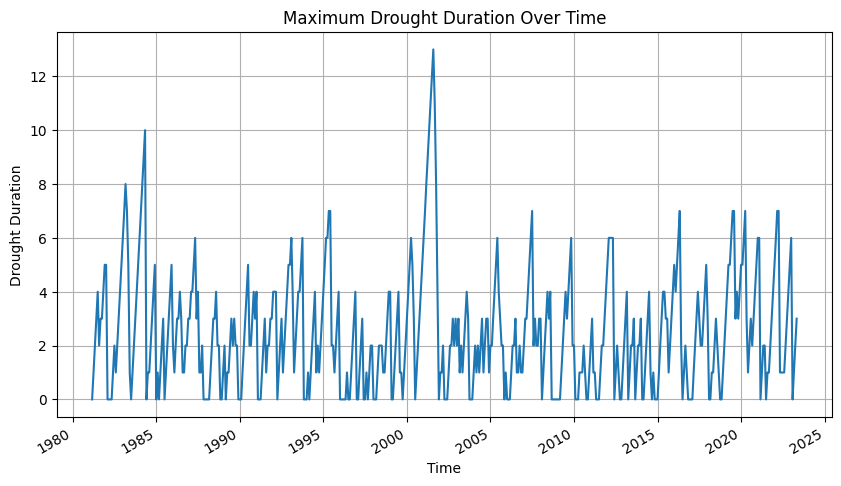

Completed!


In [16]:
import xarray as xr
import numpy as np
import os

# Open the drought event and spi data
ds_drought = xr.open_dataset('../SPI/mar/07_drought_variable/mar_cli_spi06_drought_magnitude.nc')

# Transpose the dataset to respect original dimensions
ds_drought = ds_drought.transpose('time', 'lat', 'lon')

# Preallocate an empty array for drought_duration and set all to NaN
drought_duration_arr = np.empty_like(ds_drought['drought_event'].values, dtype=float)
drought_duration_arr[:] = np.nan

# Find the first time step where not all spi_gamma_12_month values are NaN
start_time = next(i for i in range(len(ds_drought.time)) if not np.isnan(ds_drought['spi_gamma_6_month'].isel(time=i).values).all())

# Start from the determined time step
for i in range(start_time, len(ds_drought.time)):
    # For each point, check if it's a drought event
    drought_event = ds_drought['drought_event'].isel(time=i).values
    prev_drought_duration = drought_duration_arr[i-1]

    # Calculate drought duration based on your conditions
    drought_duration_arr[i] = np.where(drought_event, 1 + prev_drought_duration, 0)

# Assign the calculated values to the drought_duration in the dataset
ds_drought['drought_duration'] = (('time', 'lat', 'lon'), drought_duration_arr)

# Save the new drought duration variable to a new netCDF file
ds_drought.to_netcdf('../SPI/mar/07_drought_variable/mar_cli_spi06_drought_duration.nc')

import matplotlib.pyplot as plt
# Plot maximum drought duration at each time step
plt.figure(figsize=(10, 5))
ds_drought['drought_duration'].max(dim=['lat', 'lon']).plot()
plt.title('Maximum Drought Duration Over Time')
plt.xlabel('Time')
plt.ylabel('Drought Duration')
plt.grid(True)
plt.show()

# Close the original file
ds_drought.close()

print('Completed!')


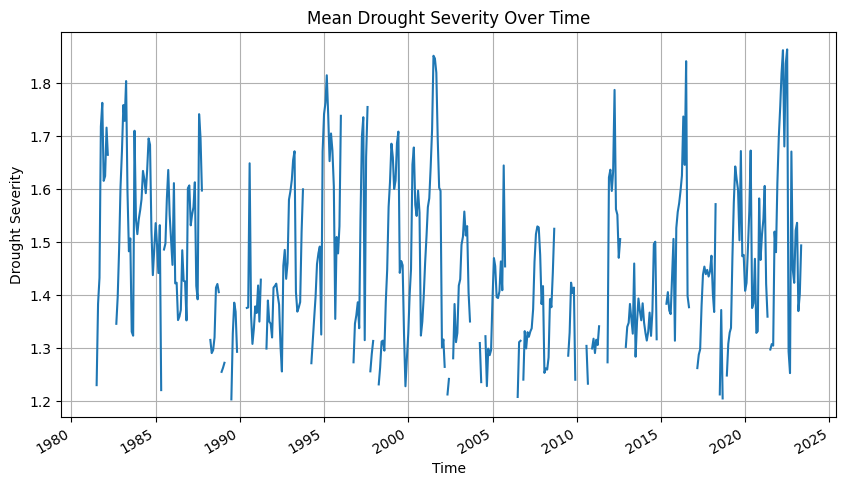

In [3]:
import xarray as xr
import numpy as np
import os

# Open the drought event and spi data
ds_drought = xr.open_dataset('../SPI/mar/07_drought_variable/mar_cli_spi06_drought_severity.nc')

# Transpose the dataset to respect original dimensions
ds_drought = ds_drought.transpose('time', 'lat', 'lon')

import matplotlib.pyplot as plt
# Plot mean drought severity at each time step
plt.figure(figsize=(10, 5))
ds_drought['drought_severity'].mean(dim=['lat', 'lon']).plot()
plt.title('Mean Drought Severity Over Time')
plt.xlabel('Time')
plt.ylabel('Drought Severity')
plt.grid(True)
plt.show()

# Close the original file
ds_drought.close()


## Drought Severity

This script performs the following steps to calculate the drought severity:

1. The script opens your drought event dataset using `xr.open_dataset`.

2. It creates a new variable 'drought_duration' with NaN (Not a Number) values of the same shape as the 'drought_event' variable in your dataset using `xr.full_like`.

3. For the first "time" data, the script checks if 'drought_event' is finite (not NaN) and assigns the 'drought_event' value to 'drought_duration' if it is finite, using the `np.where` function for conditional assignment.

4. The script starts iterating over the time points in your dataset, beginning from the second time point. For each time point, it:

   - Checks if a drought event is occurring at that time point by extracting the 'drought_event' value using `isel`.

   - Retrieves the drought duration value at the previous time point using `isel`.

   - Computes a mask for finite values in 'drought_event' using `np.isfinite`.

   - If a drought event is happening (i.e., 'drought_event' is 1), the drought duration at the current time point is calculated as the drought duration at the previous time point plus one. If no drought event is occurring, the drought duration at the current time point is set to 0. If 'drought_event' is NaN, 'drought_duration' is kept as NaN. The `np.where` function is used for this triple conditional calculation.

5. It then calculates the drought severity. First, it creates a new variable 'drought_severity' filled with NaN values but with the same shape as the 'drought_event' variable. Then, it computes a mask for non-zero and finite values in both 'drought_magnitude' and 'drought_duration'. Finally, for the masked values, it calculates the drought severity as the ratio of 'drought_magnitude' to 'drought_duration' using the `np.where` function for conditional assignment.

6. It saves the dataset, which now includes the new 'drought_severity' variable, to a new netCDF file using the `to_netcdf` method.

7. Finally, it closes the original dataset file to free up system resources.

This script assumes that the 'drought_event' and 'drought_magnitude' variables are stored in the netCDF file. Please adjust the script as necessary based on your specific data.

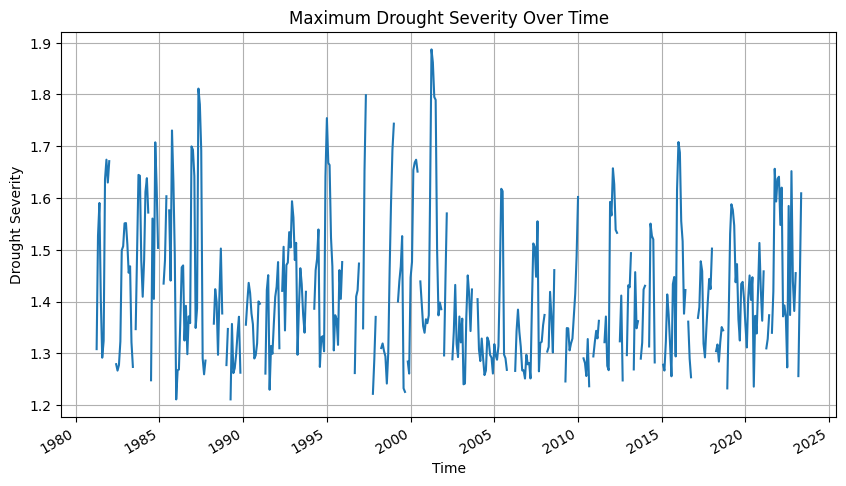

Completed!


In [17]:
import xarray as xr
import numpy as np
import os

# Open the drought event and spi data
ds_drought = xr.open_dataset('../SPI/mar/07_drought_variable/mar_cli_spi03_drought_duration.nc')

# Transpose the dataset to have 'time', 'lat', 'lon' order
ds_drought = ds_drought.transpose('time', 'lat', 'lon')

# Compute the drought_severity
ds_drought['drought_severity'] = xr.full_like(ds_drought['drought_event'], np.nan)
drought_duration = ds_drought['drought_duration']
drought_magnitude = ds_drought['drought_magnitude']

# Compute mask for non-zero and finite values
is_finite_and_nonzero = (np.isfinite(drought_magnitude) & (drought_magnitude != 0) &
                         np.isfinite(drought_duration) & (drought_duration != 0))

ds_drought['drought_severity'].values = np.where(is_finite_and_nonzero, 
                                                 drought_magnitude / drought_duration, 
                                                 np.nan)

# Save the new drought duration variable to a new netCDF file
ds_drought.to_netcdf('../SPI/mar/07_drought_variable/mar_cli_spi03_drought_severity.nc')

import matplotlib.pyplot as plt
# Plot mean drought severity at each time step
plt.figure(figsize=(10, 5))
ds_drought['drought_severity'].mean(dim=['lat', 'lon']).plot()
plt.title('Maximum Drought Severity Over Time')
plt.xlabel('Time')
plt.ylabel('Drought Severity')
plt.grid(True)
plt.show()

# Close the original file
ds_drought.close()

print('Completed!')


## SPI Classification

Classify the SPI value using column threshold below and asssigned a text value based on Class column, then save it as CSV file.

The threshold and the symbology for the SPI can follow below color codes and image.  

| Class  | Threshold  | Color  |  Hex  | RGB  |
|---|---|---|---|---|
| Exceptionally Dry  | -2.00 and below  | ![#760005](https://via.placeholder.com/15/760005/000000?text=+)  | `#760005` | rgb(118, 0, 5)  |
| Extremely Dry  | -2.00 to -1.50  | ![#ec0013](https://via.placeholder.com/15/ec0013/000000?text=+)  | `#ec0013` | rgb(236, 0, 19)  |
| Severely Dry  | -1.50 to -1.20  | ![#ffa938](https://via.placeholder.com/15/ffa938/000000?text=+)  | `#ffa938`  | rgb(255, 169, 56)  |
| Moderately Dry  | -1.20 to -0.70  | ![#fdd28a](https://via.placeholder.com/15/fdd28a/000000?text=+)  | `#fdd28a` | rgb(253, 210, 138)  |
| Abnormally Dry  | -0.70 to -0.50  | ![#fefe53](https://via.placeholder.com/15/fefe53/000000?text=+)  | `#fefe53` | rgb(254, 254, 83)  |
| Near Normal  | -0.50 to +0.50  | ![#ffffff](https://via.placeholder.com/15/ffffff/000000?text=+)  | `#ffffff`  | rgb(255, 255, 255)  |
| Abnormally Moist  | +0.50 to +0.70  | ![#a2fd6e](https://via.placeholder.com/15/a2fd6e/000000?text=+)  | `#a2fd6e` | rgb(162, 253, 110)  |
| Moderately Moist  | +0.70 to +1.20  | ![#00b44a](https://via.placeholder.com/15/00b44a/000000?text=+)  | `#00b44a` | rgb(0, 180, 74)  |
| Very Moist  | +1.20 to +1.50  | ![#008180](https://via.placeholder.com/15/008180/000000?text=+)  | `#008180` | rgb(0, 129, 128)  |
| Extremely Moist  | +1.50 to +2.00  | ![#2a23eb](https://via.placeholder.com/15/2a23eb/000000?text=+)  | `#2a23eb` | rgb(42, 35, 235)  |
| Exceptionally Moist  | +2.00 and above  | ![#a21fec](https://via.placeholder.com/15/a21fec/000000?text=+)  | `#a21fec` | rgb(162, 31, 236)  |



In [18]:
import warnings
import xarray as xr
import pandas as pd
import geopandas as gpd
from tqdm import tqdm

# Ignore warnings
warnings.filterwarnings('ignore')

# Load the point shapefile
gdf = gpd.read_file('../SPI/mar/09_shapefiles/mar_grid_005_p.shp')

# Extract the x and y coordinates of each point in gdf and round them
gdf['x'] = gdf.geometry.x.round(2)
gdf['y'] = gdf.geometry.y.round(2)
gdf['geometry'] = gpd.points_from_xy(gdf['x'], gdf['y'])

# Open the netCDF file
ds = xr.open_dataset('../SPI/mar/07_drought_variable/mar_cli_spi03_drought_severity.nc')

# Define the classification bins and labels
bins = [-float('inf'), -2.00, -1.50, -1.20, -0.70, -0.50, 0.50, 0.70, 1.20, 1.50, 2.00, float('inf')]
labels = ['Exceptionally Dry', 'Extremely Dry', 'Severely Dry', 'Moderately Dry', 'Abnormally Dry', 'Near Normal', 
          'Abnormally Moist', 'Moderately Moist', 'Very Moist', 'Extremely Moist', 'Exceptionally Moist']

# Convert the DataArray for "spi_gamma_12_month" to a DataFrame
df = ds['spi_gamma_3_month'].to_dataframe().reset_index()

# Pivot the DataFrame to have dates as columns
df_pivot = df.pivot_table(index=["lon", "lat"], columns="time", values="spi_gamma_3_month").reset_index()

# Convert the time columns to yyyymmdd format
df_pivot.columns.name = None
df_pivot.columns = [str(col) if isinstance(col, str) else col.strftime('%Y%m%d') for col in df_pivot.columns]

# Classify "spi_gamma_12_month"
for column in df_pivot.columns:
    if column not in ['lon', 'lat']:
        df_pivot[column] = pd.cut(df_pivot[column], bins=bins, labels=labels)

# Convert the DataFrame to a GeoDataFrame, with Point geometries
gdf_pivot = gpd.GeoDataFrame(df_pivot, geometry=gpd.points_from_xy(df_pivot.lon, df_pivot.lat))

# Extract the x and y coordinates of each point in gdf_pivot and round them
gdf_pivot['x'] = gdf_pivot.geometry.x.round(2)
gdf_pivot['y'] = gdf_pivot.geometry.y.round(2)
gdf_pivot['geometry'] = gpd.points_from_xy(gdf_pivot['x'], gdf_pivot['y'])

# Set the CRS of the GeoDataFrame to match the shapefile
gdf_pivot.crs = "EPSG:4326"

# Spatial join between the points and the GeoDataFrame
gdf_joined = gpd.sjoin(gdf, gdf_pivot, op='intersects', how='inner')

# Drop unnecessary columns
gdf_joined = gdf_joined.drop(columns=['x_left', 'y_left', 'index_right', 'x_right', 'y_right'])

# Save the DataFrame to a CSV file
gdf_joined.to_csv(f'../SPI/mar/08_tabular/mar_cli_spi03_classification.csv', index=False)

# Close the original file
ds.close()

print("CSV file has been created.")


CSV file has been created.


## Convert to CSV

Convert all variables into csv and spatially join with the point grid from the admin2 level boundary. As the final CSV output will be the variable along with information on the admin level.

In [19]:
import warnings
import xarray as xr
import pandas as pd
import geopandas as gpd
from tqdm import tqdm

# Ignore warnings
warnings.filterwarnings('ignore')

# Load the point shapefile
gdf = gpd.read_file('../SPI/mar/09_shapefiles/mar_grid_005_p.shp')

# Extract the x and y coordinates of each point in gdf and round them
gdf['x'] = gdf.geometry.x.round(2)
gdf['y'] = gdf.geometry.y.round(2)
gdf['geometry'] = gpd.points_from_xy(gdf['x'], gdf['y'])

# Open the netCDF file
ds = xr.open_dataset('../SPI/mar/07_drought_variable/mar_cli_spi03_drought_severity.nc')

# List of variables to convert to csv
variables = ["spi_gamma_3_month", "drought_event", "interarrival_times", "drought_magnitude", "drought_duration", "drought_severity"]

# Iterate over each variable
for var in tqdm(variables, desc='Converting variables'):
    # Convert the DataArray to a DataFrame
    df = ds[var].to_dataframe().reset_index()
    
    # Pivot the DataFrame to have dates as columns
    df_pivot = df.pivot_table(index=["lon", "lat"], columns="time", values=var).reset_index()
    
    # Convert the time columns to yyyymmdd format
    df_pivot.columns.name = None
    df_pivot.columns = [str(col) if isinstance(col, str) else col.strftime('%Y%m%d') for col in df_pivot.columns]
    
    # Convert the DataFrame to a GeoDataFrame, with Point geometries
    gdf_pivot = gpd.GeoDataFrame(df_pivot, geometry=gpd.points_from_xy(df_pivot.lon, df_pivot.lat))

    # Extract the x and y coordinates of each point in gdf_pivot and round them
    gdf_pivot['x'] = gdf_pivot.geometry.x.round(2)
    gdf_pivot['y'] = gdf_pivot.geometry.y.round(2)
    gdf_pivot['geometry'] = gpd.points_from_xy(gdf_pivot['x'], gdf_pivot['y'])

    # Set the CRS of the GeoDataFrame to match the shapefile
    gdf_pivot.crs = "EPSG:4326"
    
    # Spatial join between the points and the GeoDataFrame
    gdf_joined = gpd.sjoin(gdf, gdf_pivot, op='intersects', how='inner')
    
    # Drop unnecessary columns
    gdf_joined = gdf_joined.drop(columns=['x_left', 'y_left', 'index_right', 'x_right', 'y_right'])

    # Save the DataFrame to a CSV file
    gdf_joined.to_csv(f'../SPI/mar/08_tabular/mar_cli_spi03_{var}.csv', index=False)
    
# Close the original file
ds.close()

print("CSV files have been created.")


Converting variables: 100%|██████████████████████████████████████████████| 6/6 [02:00<00:00, 20.03s/it]

CSV files have been created.


## Map Visualization

Visual interpretation of each variable on a map

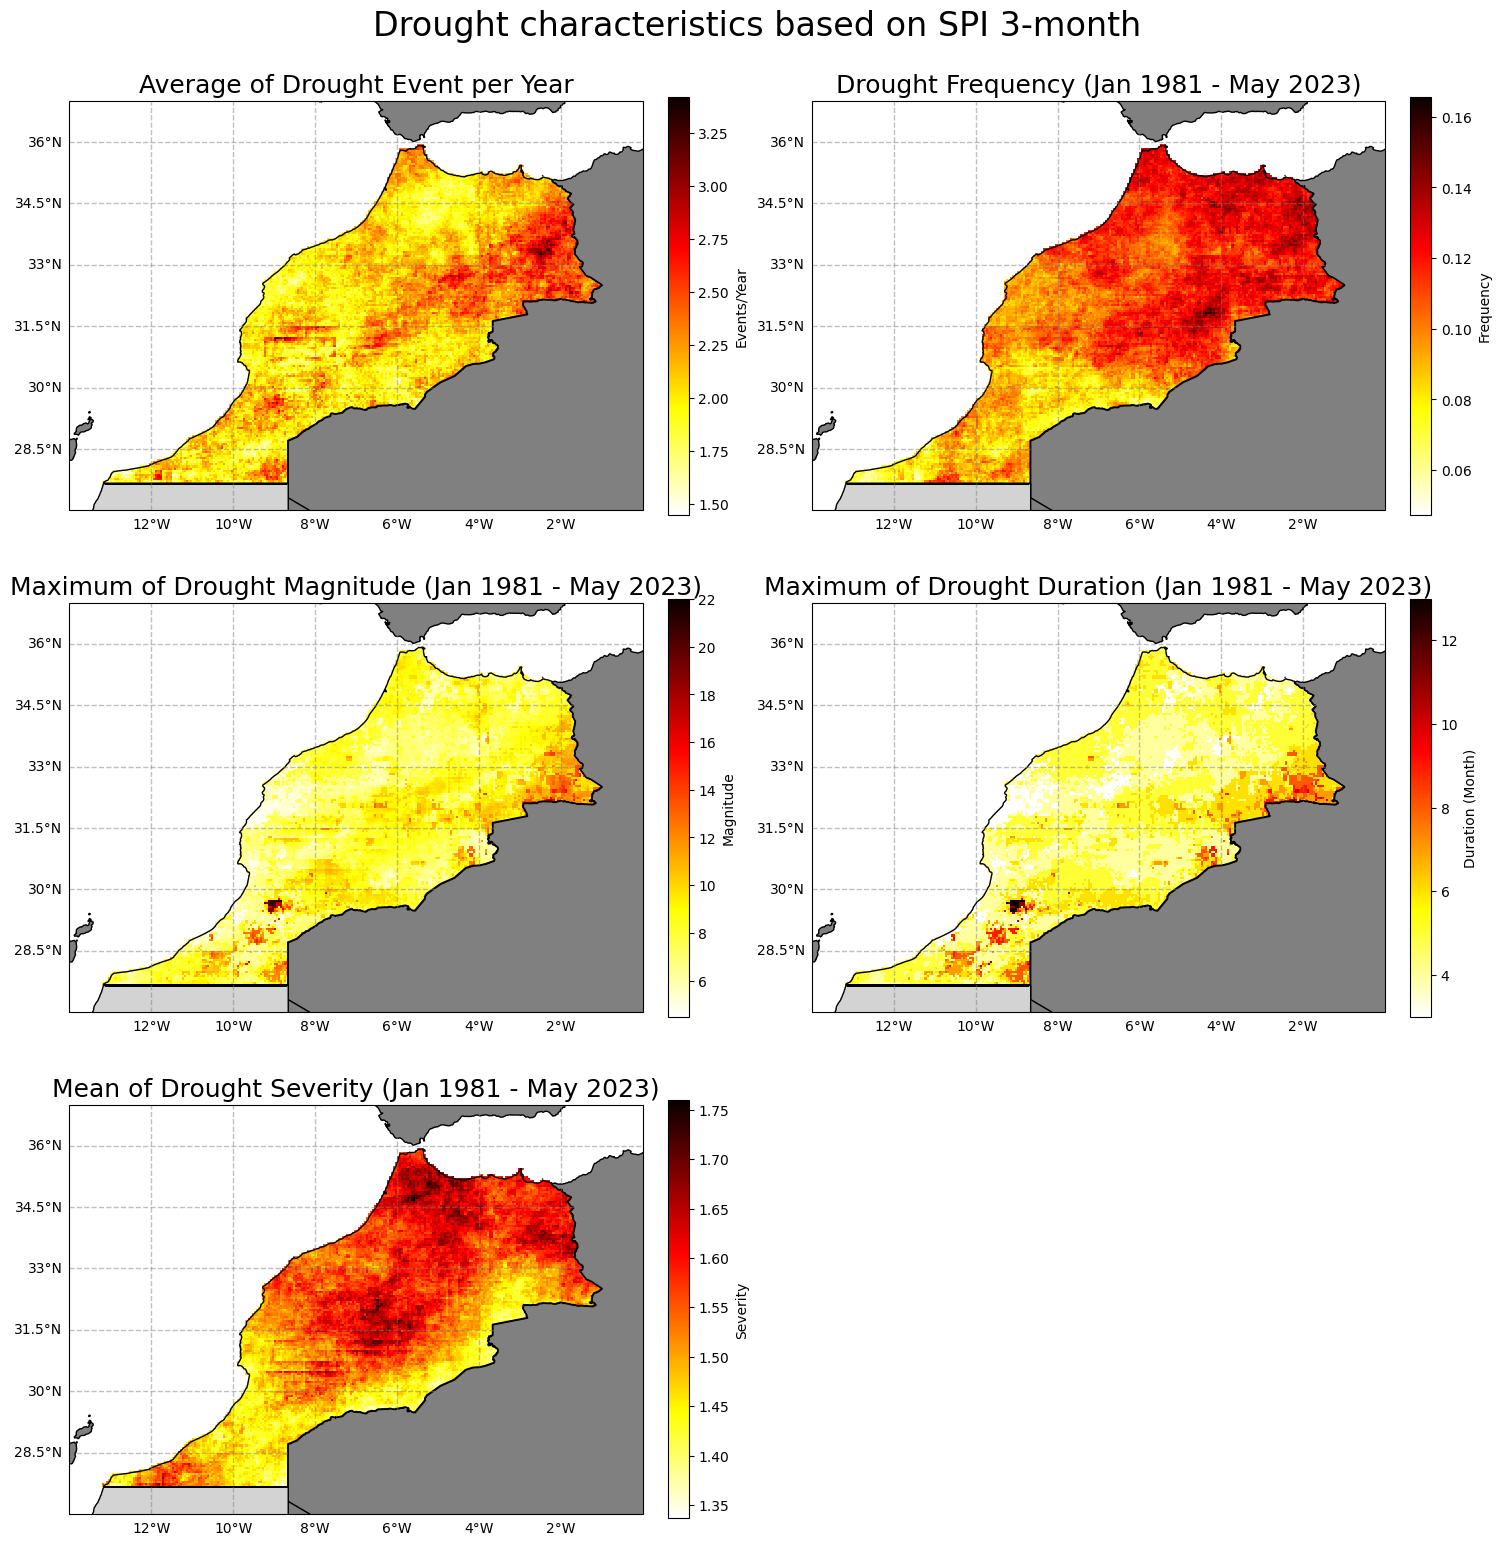

In [20]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import cartopy.feature as cfeature

# Open the dataset
ds_drought = xr.open_dataset('../SPI/mar/07_drought_variable/mar_cli_spi03_drought_severity.nc')

# Resample to yearly frequency, summing over all months in each year
ds_yearly = ds_drought.resample(time='1Y').sum('time')

# Compute the average number of events per year, excluding NaN and zero values
num_events = ds_yearly['drought_event'].where(ds_yearly['drought_event'] > 0).mean(dim='time', skipna=True)

# Compute the other statistics
total_count = ds_drought['drought_event'].count(dim='time')
frequency = ds_drought['drought_event'].sum(dim='time') / total_count
max_magnitude = ds_drought['drought_magnitude'].max(dim='time', skipna=True)
max_duration = ds_drought['drought_duration'].max(dim='time', skipna=True)
mean_severity = ds_drought['drought_severity'].mean(dim='time', skipna=True)

# List of the computed statistics and their titles
statistics = [num_events, frequency, max_magnitude, max_duration, mean_severity]
titles = ["Average of Drought Event per Year", "Drought Frequency (Jan 1981 - May 2023)", 
          "Maximum of Drought Magnitude (Jan 1981 - May 2023)", "Maximum of Drought Duration (Jan 1981 - May 2023)", 
          "Mean of Drought Severity (Jan 1981 - May 2023)"]
colorbars = ["Events/Year", "Frequency", "Magnitude", "Duration (Month)", "Severity"]
cmaps = ['hot_r', 'hot_r', 'hot_r', 'hot_r', 'hot_r']

# Read the shapefile
shapefile = gpd.read_file('../SPI/mar/09_shapefiles/WB_GAD_ADM0_and_Disputes.shp')

# Define a function to add administration boundaries with specific colors
def add_admin_boundaries(ax):
    # Loop through each row in the shapefile dataframe
    for index, row in shapefile.iterrows():
        if row['NAM_0'] == "Morocco":
            facecolor = 'none'
        elif row['NAM_0'] == "Western Sahara":
            facecolor = 'lightgray'
        else:
            facecolor = 'gray'
        
        # Add the feature with the specified color
        ax.add_feature(cfeature.ShapelyFeature([row['geometry']], ccrs.PlateCarree(), edgecolor='black', facecolor=facecolor))

# Define the extent of your map for Morocco
lon_min, lon_max, lat_min, lat_max = -14, 0, 27, 37

# Create a figure with subplots arranged in 2 rows and 3 columns
fig, axs = plt.subplots(3, 2, figsize=(15, 15), subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()  # Flatten the axes array for easy looping

# Set colorbar size
cbar_kwargs = {'fraction': 0.046, 'pad': 0.04}

# Loop over the subplots to create each map
for i, (ax, stat, title, cbar_title, cmap) in enumerate(zip(axs, statistics, titles, colorbars, cmaps)):
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], ccrs.PlateCarree())
    stat = stat.where(~np.isnan(stat))  # Add this line to mask NaN values
    im = stat.plot(ax=ax, cmap=cmap, add_colorbar=False, extend='both')  # Plot without colorbar first
    fig.colorbar(im, ax=ax, label=cbar_title, **cbar_kwargs)  # Then add colorbar with label
    ax.set_title(title, fontsize=18)  # Set title with increased font size
    add_admin_boundaries(ax)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

# Remove the last subplot if it's not used
if i < len(axs) - 1:
    fig.delaxes(axs[-1])

# Automatically adjust subplot parameters to give specified padding
plt.tight_layout()

# Adjust the space between rows
plt.subplots_adjust(hspace=0.2)

# Add the main title and save the chart
fig.suptitle("Drought characteristics based on SPI 3-month", fontsize=24, y=1.03)
fig.savefig("../SPI/mar/10_images/mar_cli_spi03_drought_characteristics_chirps.png", bbox_inches='tight', dpi=300)

# Show the plot
plt.show()

# Close the original file
ds_drought.close()


Visual interpretation of all time scale on a map

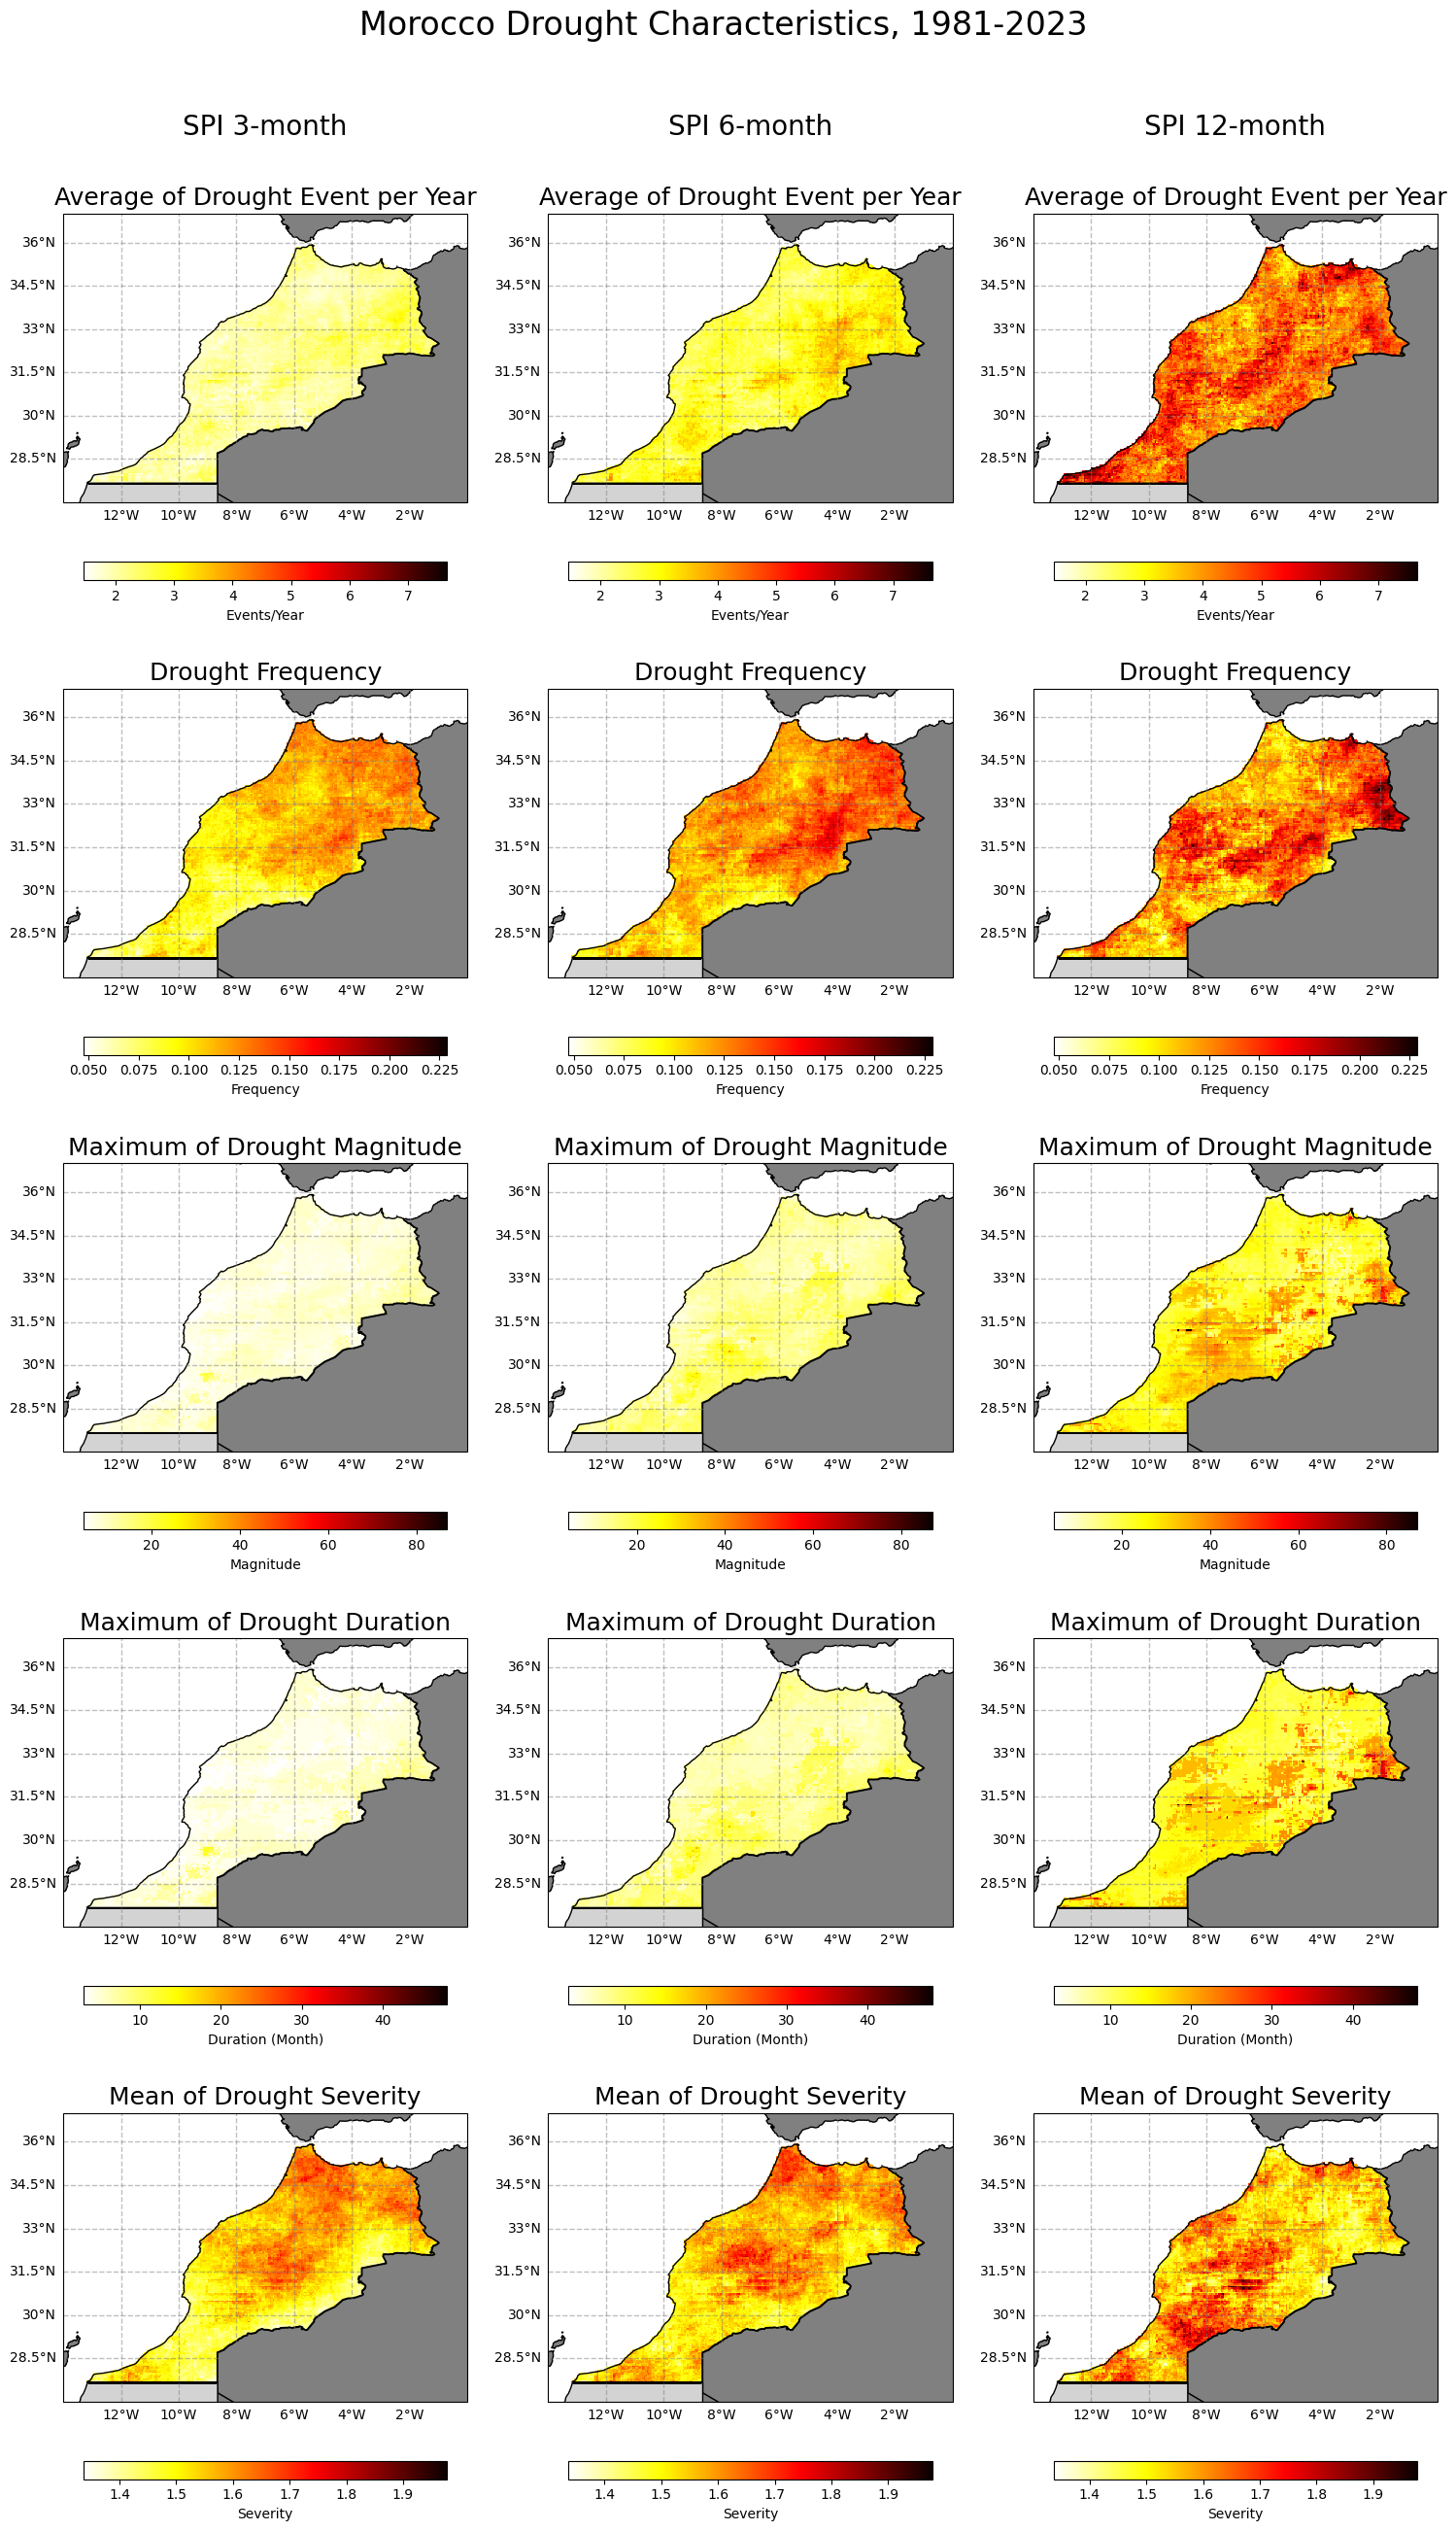

In [39]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import cartopy.feature as cfeature

files = ["../SPI/mar/07_drought_variable/mar_cli_spi03_drought_severity.nc", 
         "../SPI/mar/07_drought_variable/mar_cli_spi06_drought_severity.nc", 
         "../SPI/mar/07_drought_variable/mar_cli_spi12_drought_severity.nc"]

# Titles for each column
column_titles = ["SPI 3-month", "SPI 6-month", "SPI 12-month"]

# Read the shapefile
shapefile = gpd.read_file('../SPI/mar/09_shapefiles/WB_GAD_ADM0_and_Disputes.shp')

# Define the extent of your map for Morocco
lon_min, lon_max, lat_min, lat_max = -14, 0, 27, 37

# Adjust the cbar_kwargs
cbar_kwargs = {
    'fraction': 0.046,
    'pad': 0.15,  # Increase the padding to move the colorbar down.
    'orientation': 'horizontal'
}

titles = ["Average of Drought Event per Year", "Drought Frequency", 
          "Maximum of Drought Magnitude", "Maximum of Drought Duration", 
          "Mean of Drought Severity"]
colorbars = ["Events/Year", "Frequency", "Magnitude", "Duration (Month)", "Severity"]
cmaps = ['hot_r', 'hot_r', 'hot_r', 'hot_r', 'hot_r']

# Create a figure with subplots
fig, axs = plt.subplots(5, 3, figsize=(15, 25), subplot_kw={'projection': ccrs.PlateCarree()})

# Function to compute the statistics
def compute_statistics(ds_drought):
    ds_yearly = ds_drought.resample(time='1Y').sum('time')
    num_events = ds_yearly['drought_event'].where(ds_yearly['drought_event'] > 0).mean(dim='time', skipna=True)
    total_count = ds_drought['drought_event'].count(dim='time')
    frequency = ds_drought['drought_event'].sum(dim='time') / total_count
    max_magnitude = ds_drought['drought_magnitude'].max(dim='time', skipna=True)
    max_duration = ds_drought['drought_duration'].max(dim='time', skipna=True)
    mean_severity = ds_drought['drought_severity'].mean(dim='time', skipna=True)
    return [num_events, frequency, max_magnitude, max_duration, mean_severity]

# Define a function to add administration boundaries with specific colors
def add_admin_boundaries(ax):
    for index, row in shapefile.iterrows():
        if row['NAM_0'] == "Morocco":
            facecolor = 'none'
        elif row['NAM_0'] == "Western Sahara":
            facecolor = 'lightgray'
        else:
            facecolor = 'gray'
        ax.add_feature(cfeature.ShapelyFeature([row['geometry']], ccrs.PlateCarree(), edgecolor='black', facecolor=facecolor))

# Pre-calculate the global minimum and maximum for each statistic
global_mins = [float('inf')] * 5  # Initialize with very large numbers
global_maxs = [float('-inf')] * 5  # Initialize with very small numbers

for file in files:
    ds_drought = xr.open_dataset(file)
    stats = compute_statistics(ds_drought)
    
    for i, stat in enumerate(stats):
        global_mins[i] = min(global_mins[i], stat.min().values)
        global_maxs[i] = max(global_maxs[i], stat.max().values)
    ds_drought.close()

# Now, plot with consistent color ranges per row
for col, file in enumerate(files):
    ds_drought = xr.open_dataset(file)
    stats = compute_statistics(ds_drought)

    for row, (stat, title, cbar_title, cmap) in enumerate(zip(stats, titles, colorbars, cmaps)):
        ax = axs[row, col]
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], ccrs.PlateCarree())
        im = stat.plot(ax=ax, cmap=cmap, add_colorbar=False, extend='both', vmin=global_mins[row], vmax=global_maxs[row])
        fig.colorbar(im, ax=ax, label=cbar_title, **cbar_kwargs)
        ax.set_title(title, fontsize=18)
        add_admin_boundaries(ax)
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False

    # Add column titles to indicate the SPI scale above the existing titles
    axs[0, col].annotate(column_titles[col], xy=(0.5, 1.3), xycoords='axes fraction', ha='center', va='center', fontsize=20)

    ds_drought.close()

# Automatically adjust subplot parameters to give specified padding
plt.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0.2)  # Adjusted spacing between subplots

# Add the main title at top of image
fig.suptitle("Morocco Drought Characteristics, 1981-2023", fontsize=24, y=1.04)

# Save and show the plot
fig.savefig("../SPI/mar/10_images/mar_cli_spi_drought_characteristics_chirps.png", bbox_inches='tight', dpi=300)
plt.show()


## Chart visualization

In addition to geographical maps, time series charts offer a compelling visualization tool that vividly captures the evolution of drought conditions. These charts, with their month-by-month and year-by-year granularity, effectively illustrate the changing dynamics of drought. Furthermore, they provide insightful details on the percentage of regions affected over time, painting a comprehensive picture of how droughts impact different areas periodically.

### Admin 0

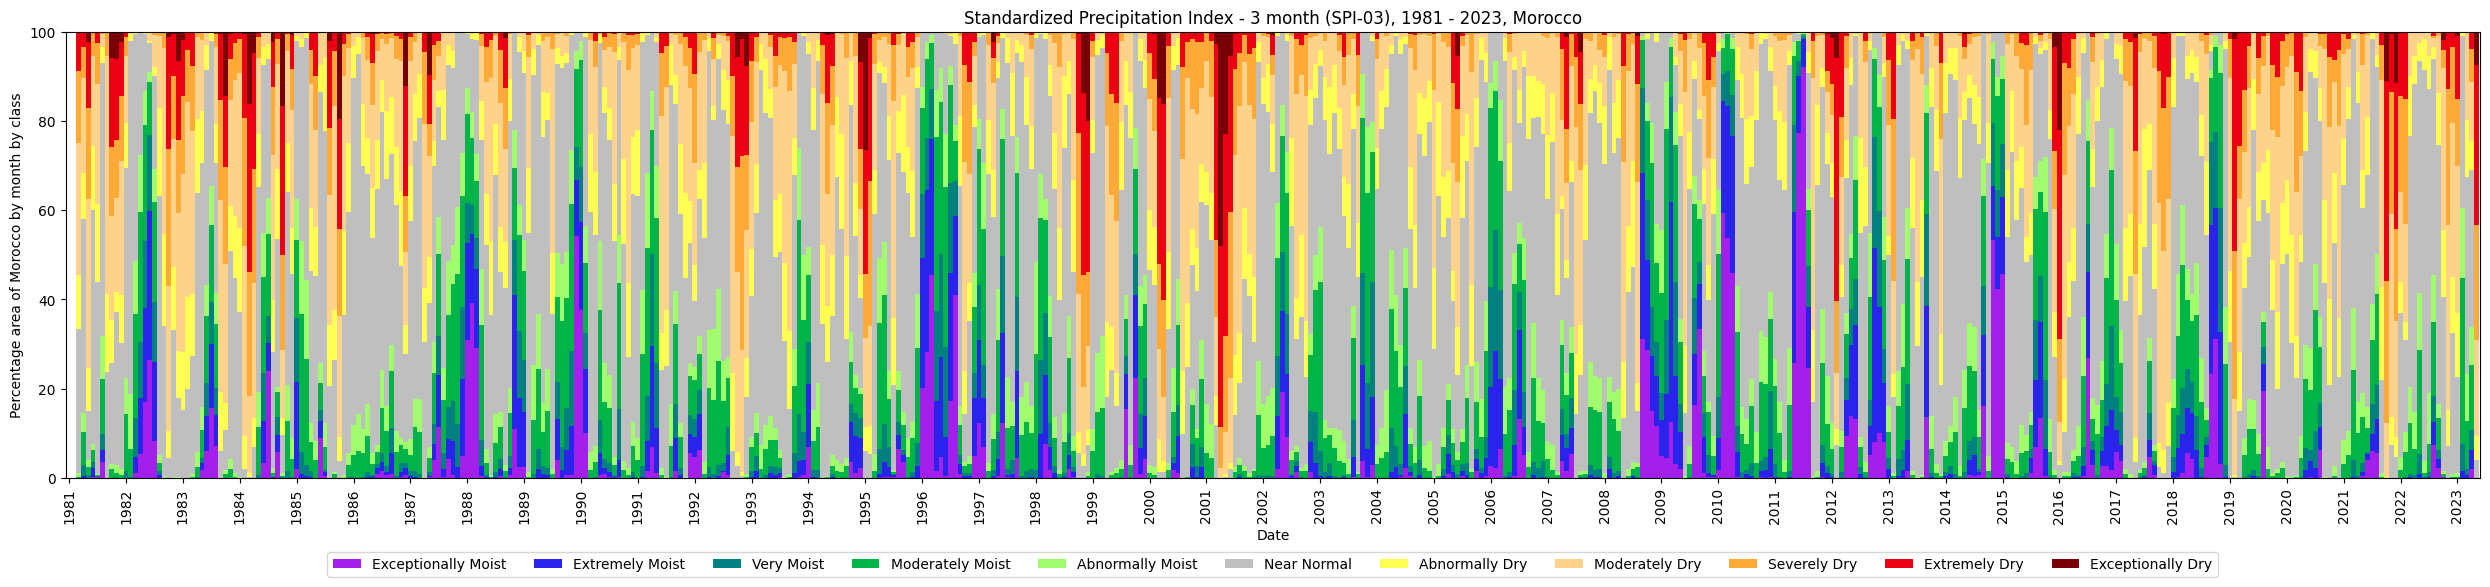

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file
data = pd.read_csv('../SPI/mar/08_tabular/mar_cli_spi03_spi_gamma_3_month.csv')

unique_countries = data['adm0_name'].unique()
if len(unique_countries) == 1:
    country_name = unique_countries[0]
else:
    raise ValueError("The dataset contains data for multiple countries.")
adm0_data = data[data['adm0_name'] == country_name]

# Define the classification bins and labels
bins = [-float('inf'), -2.00, -1.50, -1.20, -0.70, -0.50, 0.50, 0.70, 1.20, 1.50, 2.00, float('inf')]
labels = ['Exceptionally Dry', 'Extremely Dry', 'Severely Dry', 'Moderately Dry', 'Abnormally Dry', 'Near Normal', 'Abnormally Moist', 'Moderately Moist', 'Very Moist', 'Extremely Moist', 'Exceptionally Moist']
colors = ['#760005', '#ec0013', '#ffa938', '#fdd28a', '#fefe53', '#bfbfbf', '#a2fd6e', '#00b44a', '#008180', '#2a23eb', '#a21fec']

# Melt dataframe for the SPI columns into long format
spi_data = adm0_data.melt(id_vars=['adm0_name'], value_vars=[col for col in adm0_data.columns if col.startswith('19') or col.startswith('20')], var_name='Date', value_name='SPI')

# Drop rows with NaN values
spi_data.dropna(inplace=True)

# Classify the SPI values
spi_data['Classification'] = pd.cut(spi_data['SPI'], bins=bins, labels=labels)

# Group by Date and Classification and count
grouped = spi_data.groupby(['Date', 'Classification']).size().unstack().fillna(0)

# Convert counts to percentages
grouped_percentage = grouped.divide(grouped.sum(axis=1), axis=0) * 100

# Add missing months for the starting year
start_year = int(grouped_percentage.index[0][:4])
months_missing = int(grouped_percentage.index[0][4:6]) - 1

for i in range(months_missing, 0, -1):
    new_index = f"{start_year}{i:02}01"
    grouped_percentage.loc[new_index] = [0]*len(labels)
    
grouped_percentage.sort_index(inplace=True)

# Reverse the order of colors, bins, and labels for the desired order in the stacked chart
colors = colors[::-1]
bins = bins[::-1]
labels = labels[::-1]
grouped_percentage = grouped_percentage[labels]

# Create a stacked bar chart with increased figure width and bar width
fig, ax = plt.subplots(figsize=(25, 6))
grouped_percentage.plot(kind='bar', stacked=True, color=colors, width=1.0, ax=ax)

# Set x-ticks at the start of each year
yearly_ticks = [str(year) + '0101' for year in range(start_year, int(grouped_percentage.index[-1][:4]) + 1)]
ax.set_xticks([grouped_percentage.index.get_loc(tick) for tick in yearly_ticks])
ax.set_xticklabels([tick[:4] for tick in yearly_ticks])

# Set the y-axis limits
ax.set_ylim(0, 100)

# Plot configuration
plt.xlabel('Date')
plt.ylabel('Percentage area of Morocco by month by class')
plt.title(f'Standardized Precipitation Index - 3 month (SPI-03), 1981 - 2023, {country_name}')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(labels), fontsize='medium')
plt.tight_layout()

# Remove the space in the admin name, to make sure the image output filename doesn't have space too
filename_country = country_name.replace(" ", "")

plt.savefig(f"../SPI/mar/10_images/charts/spi_3_month_{filename_country}.png", bbox_inches="tight", dpi=300)

# Preview the plot
plt.show()


### Admin 1

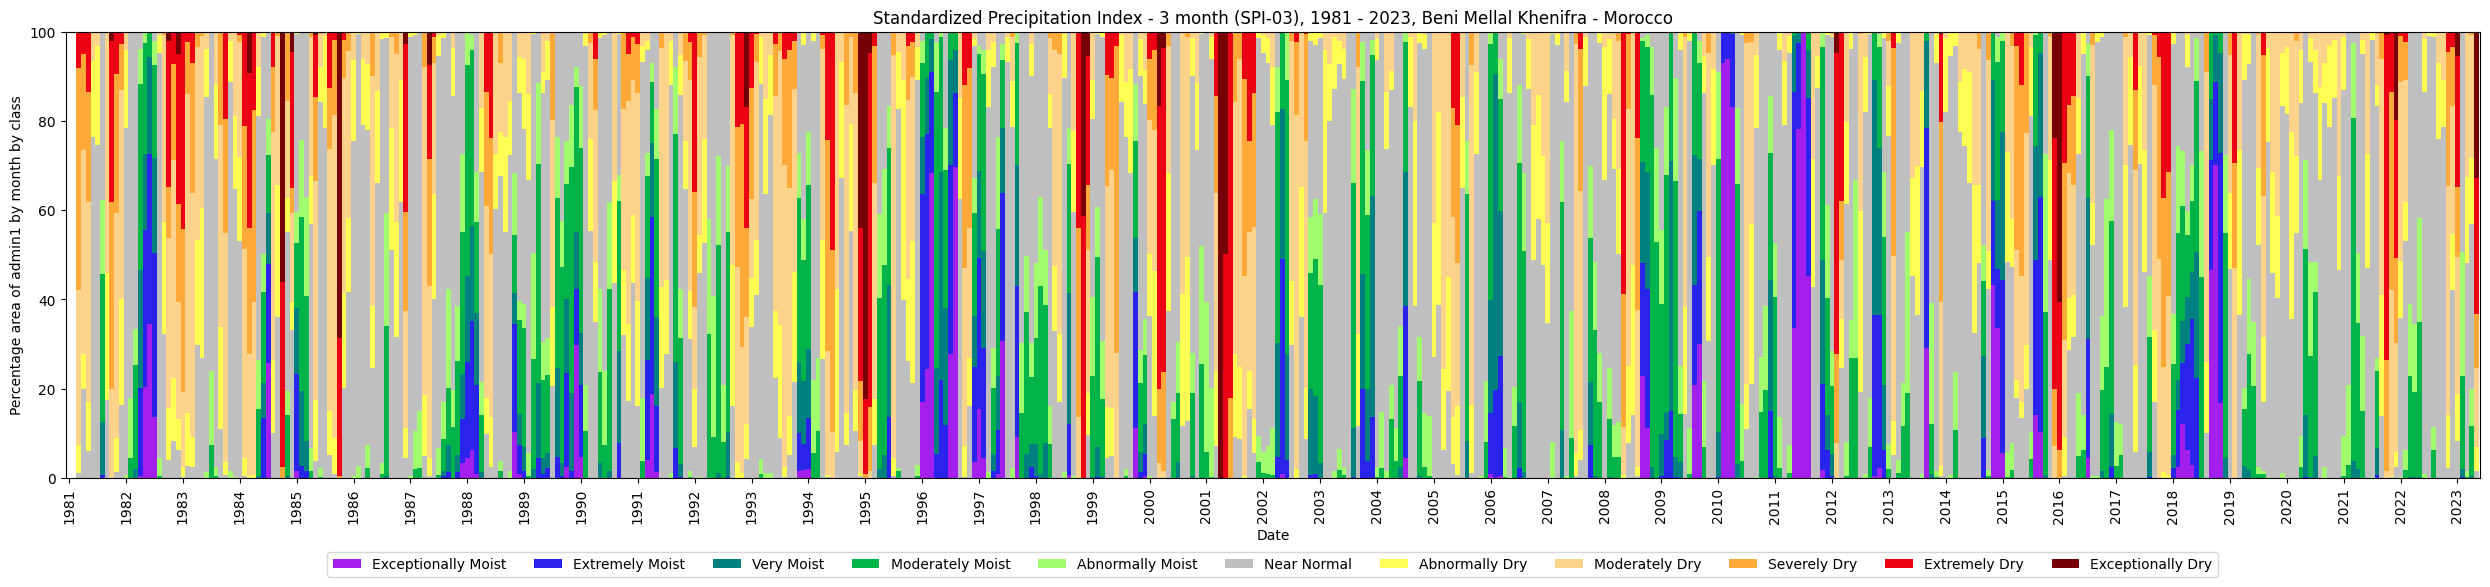

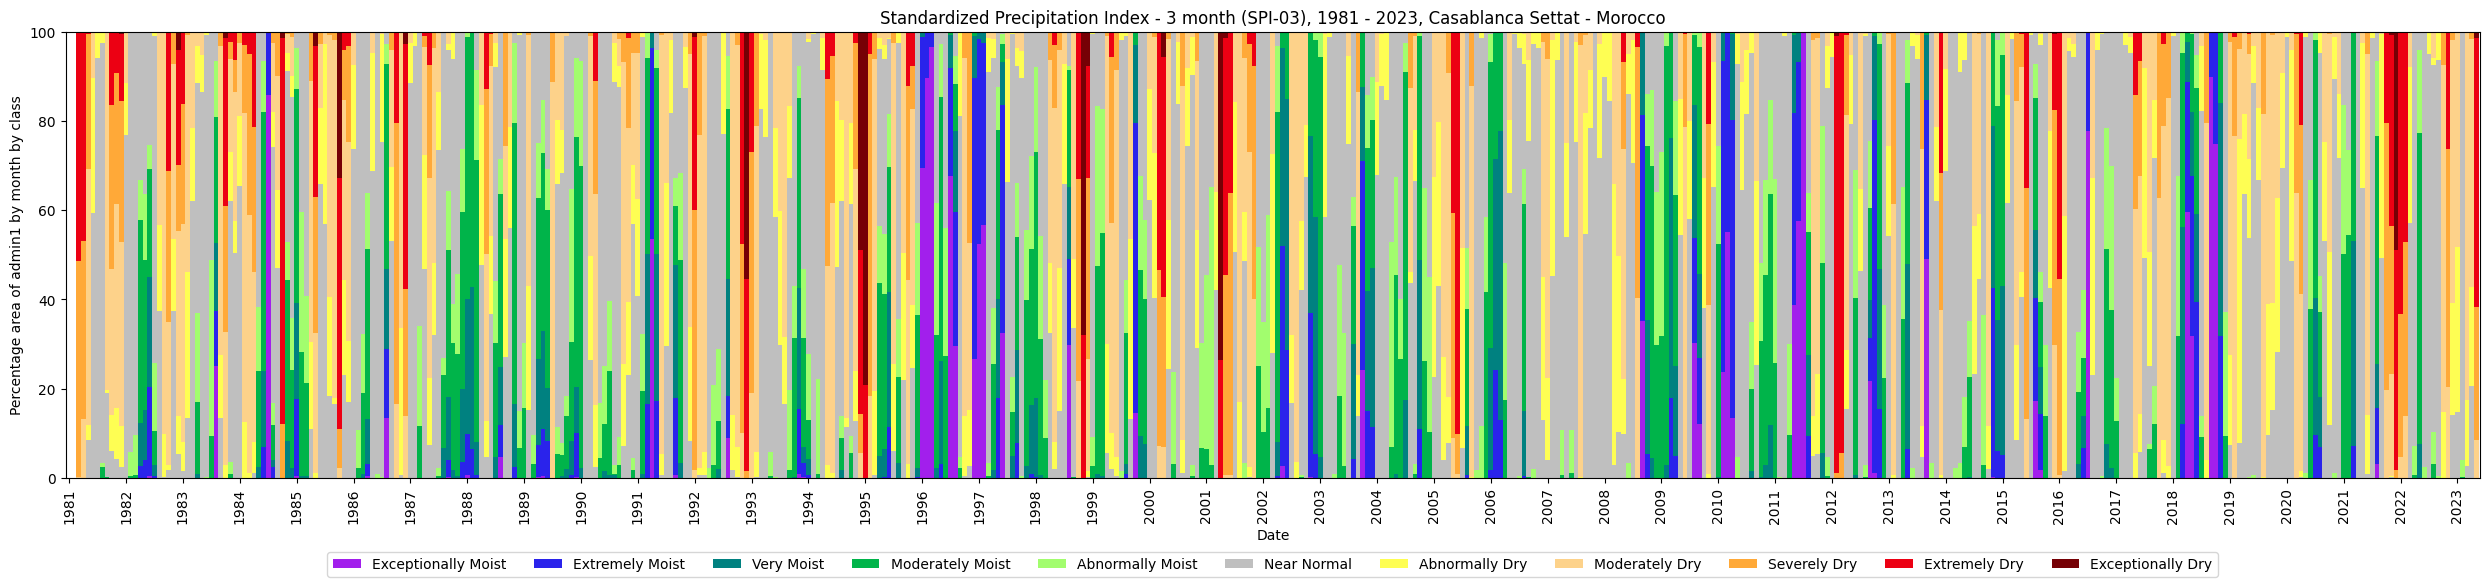

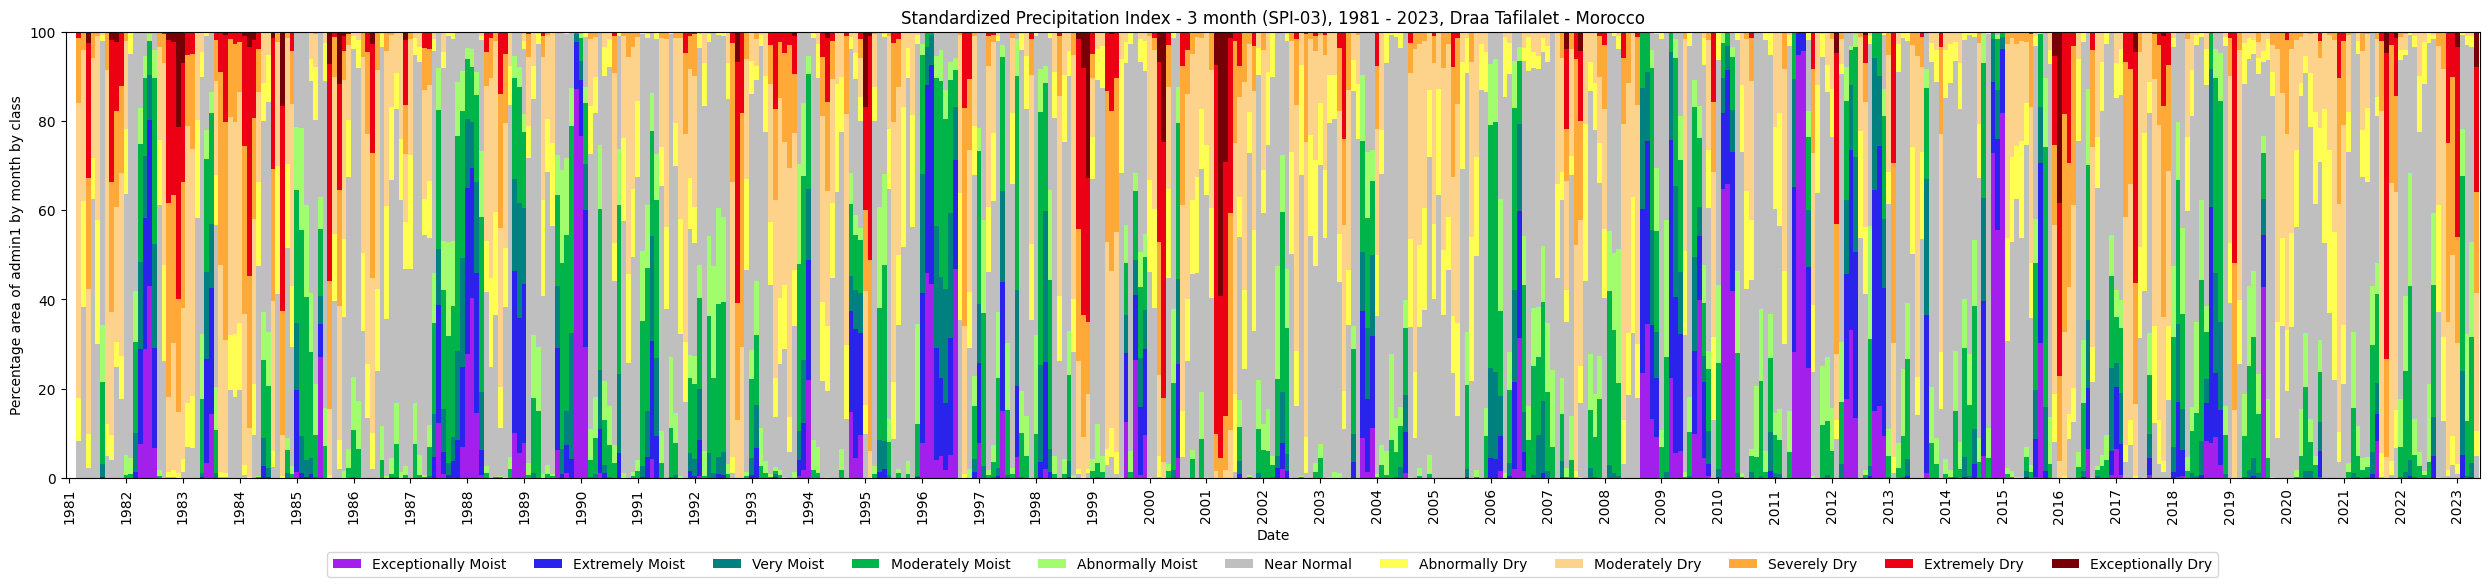

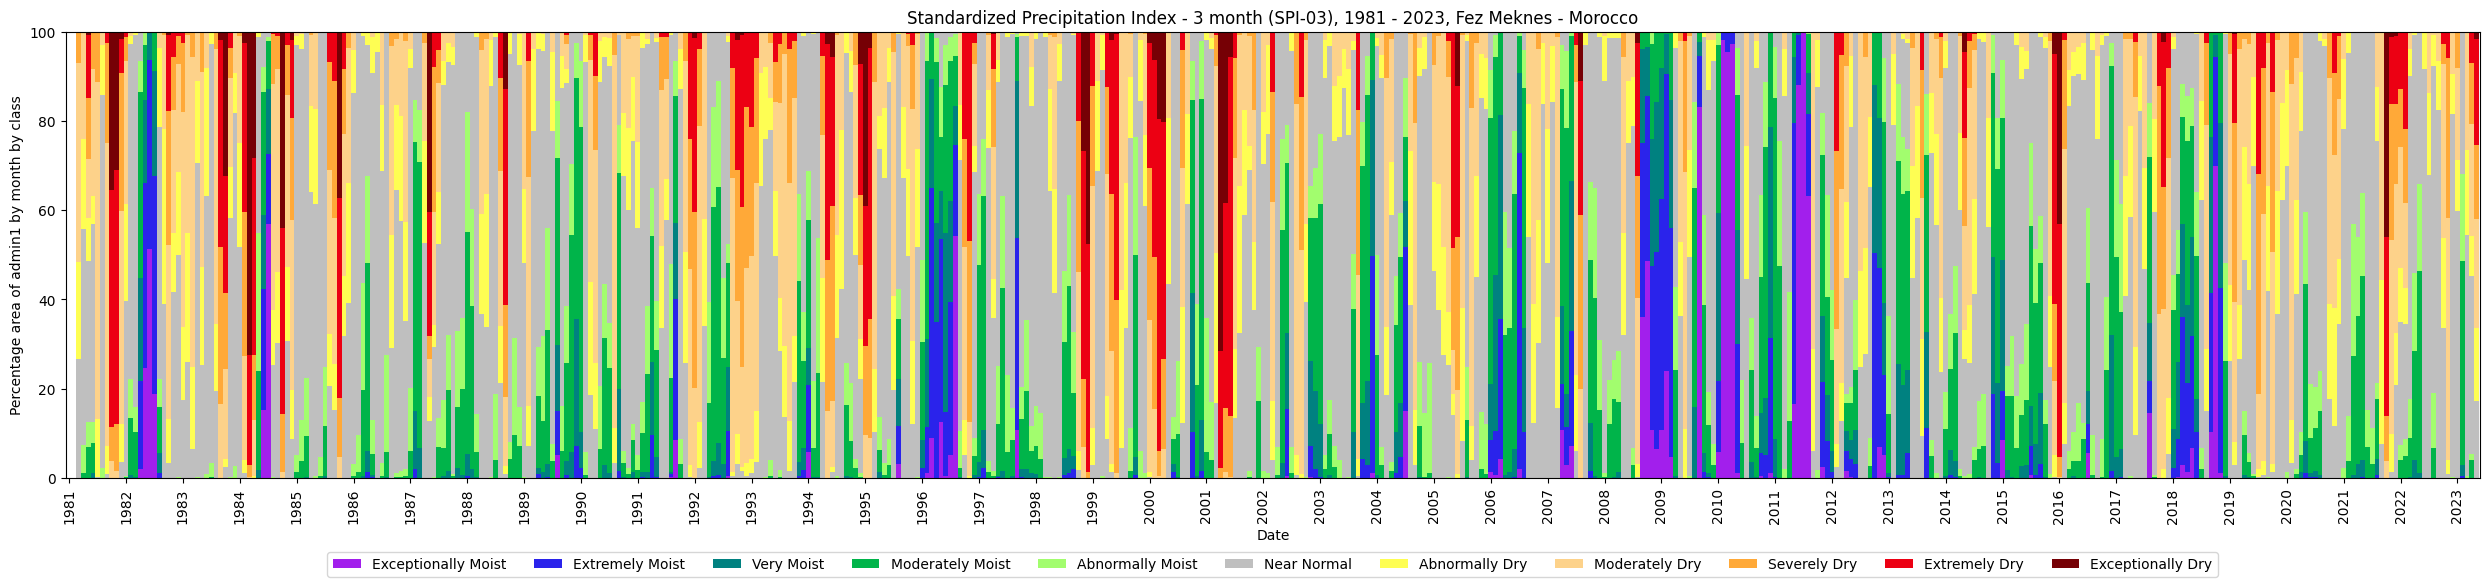

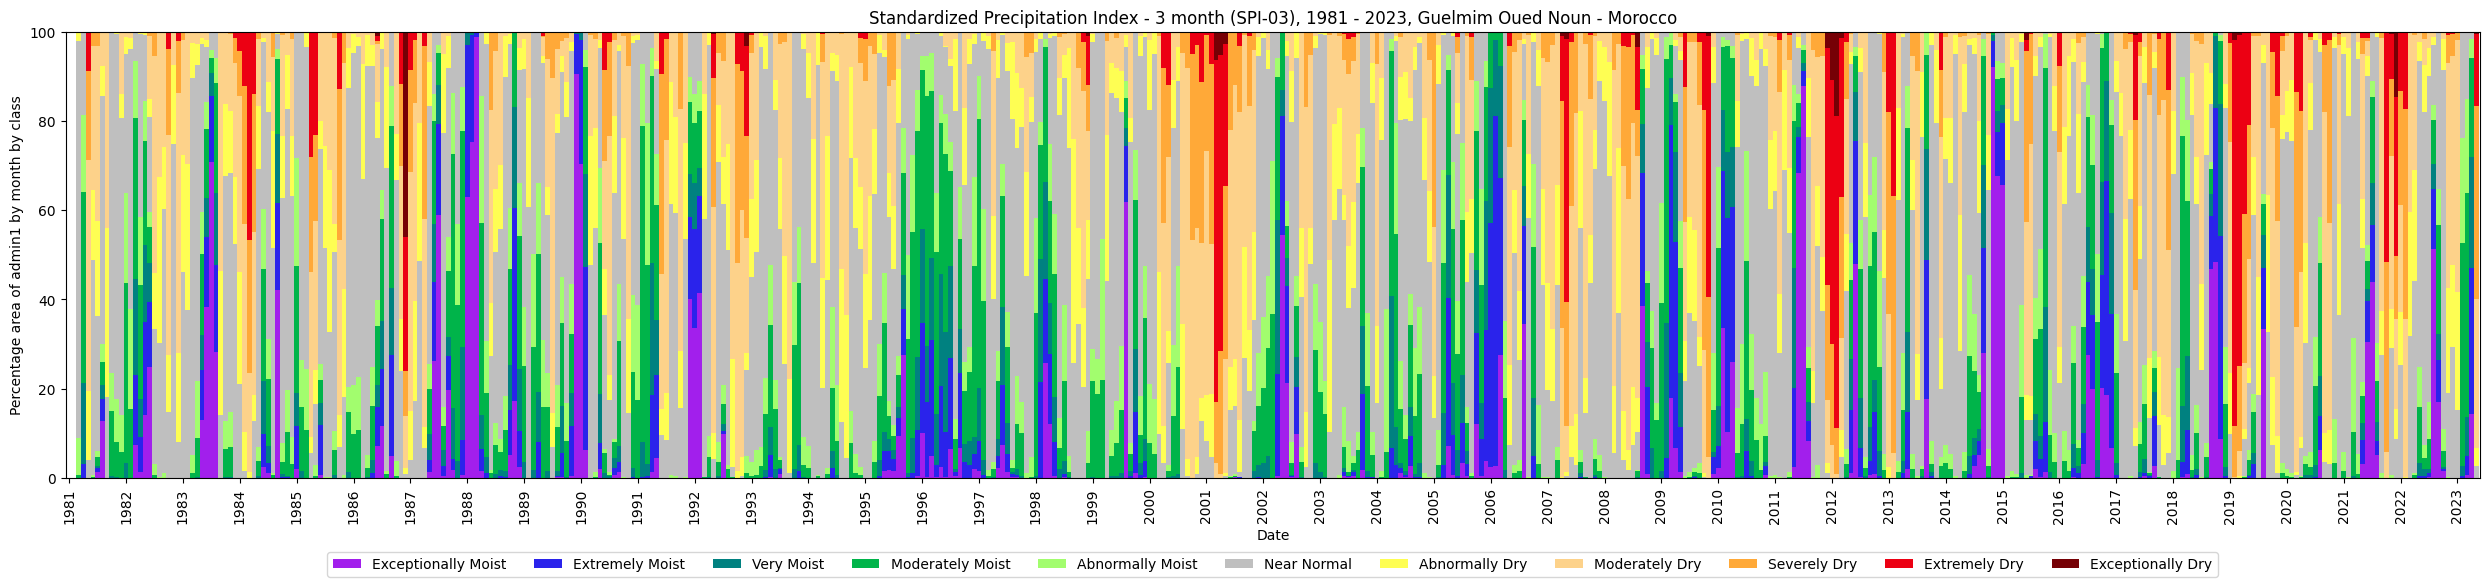

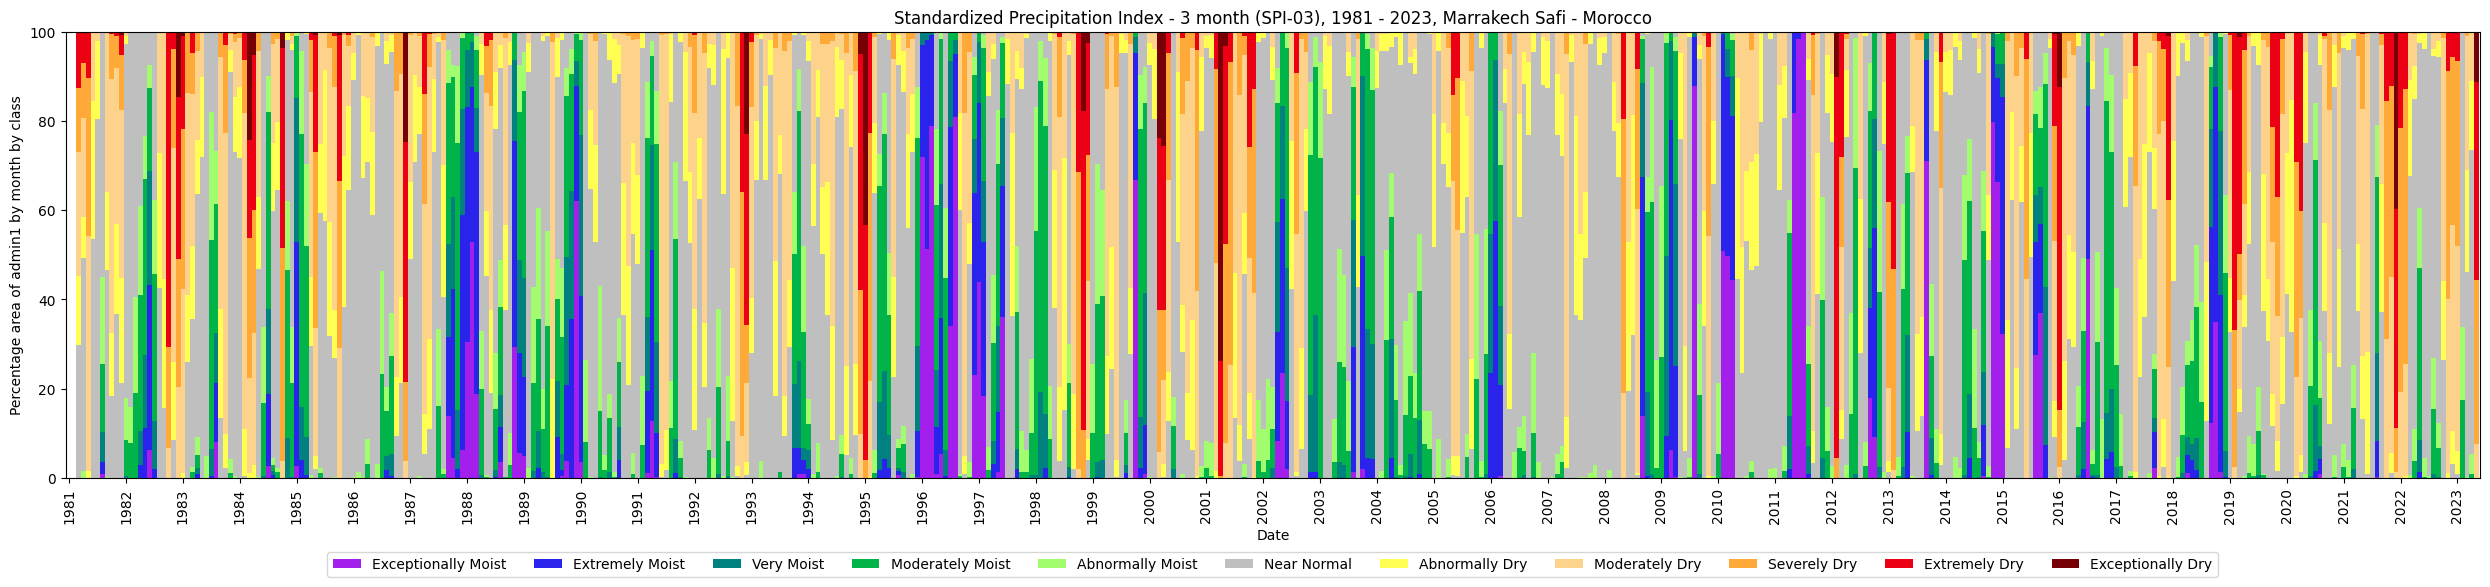

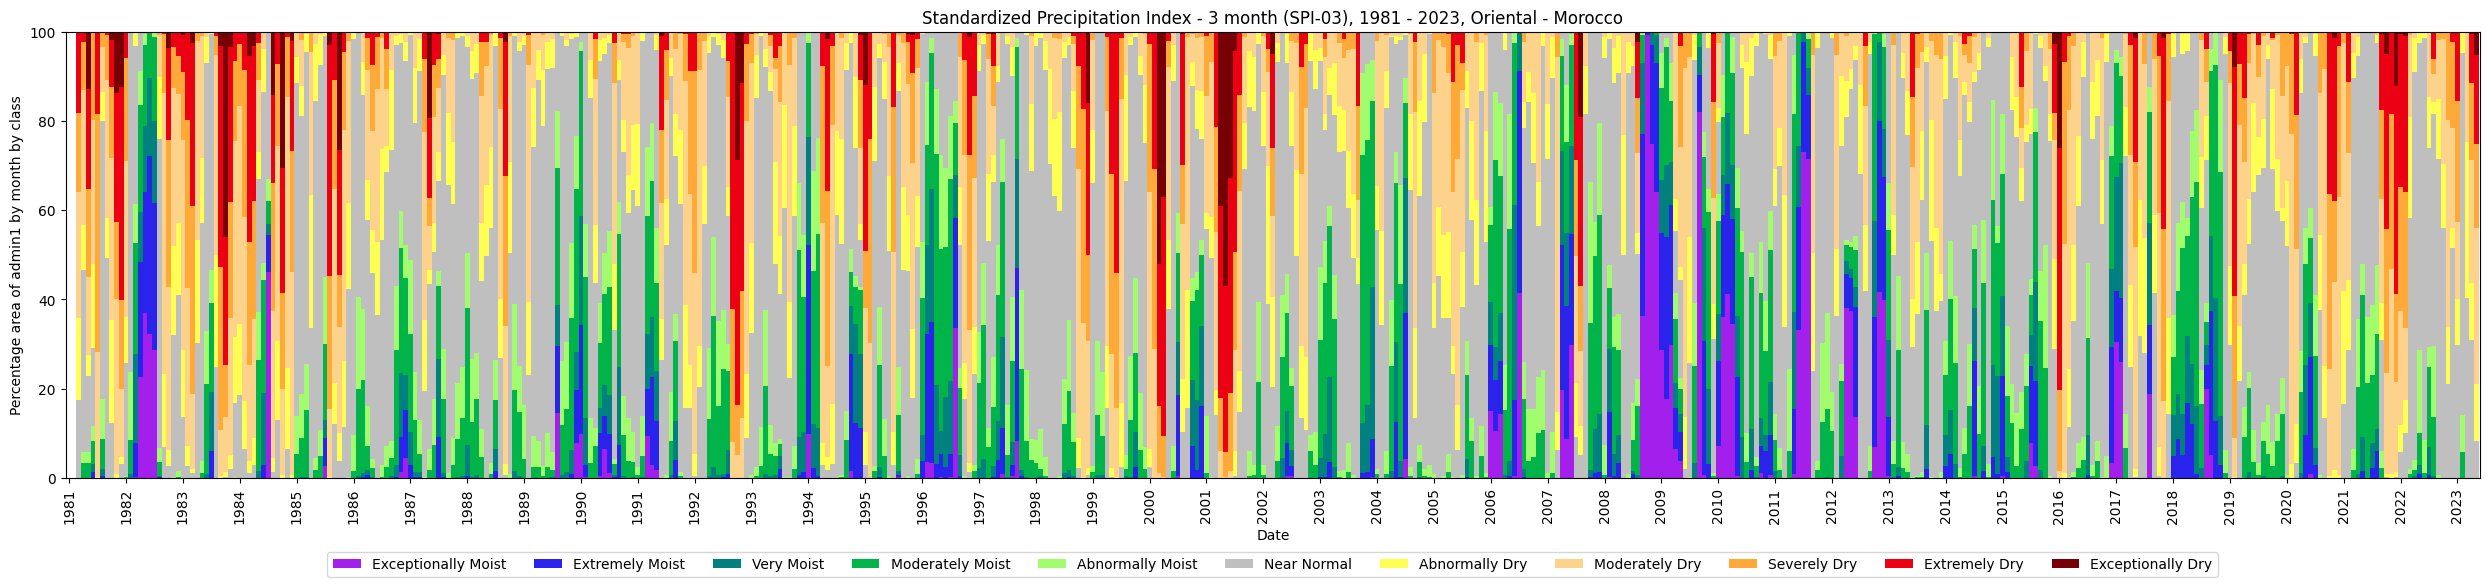

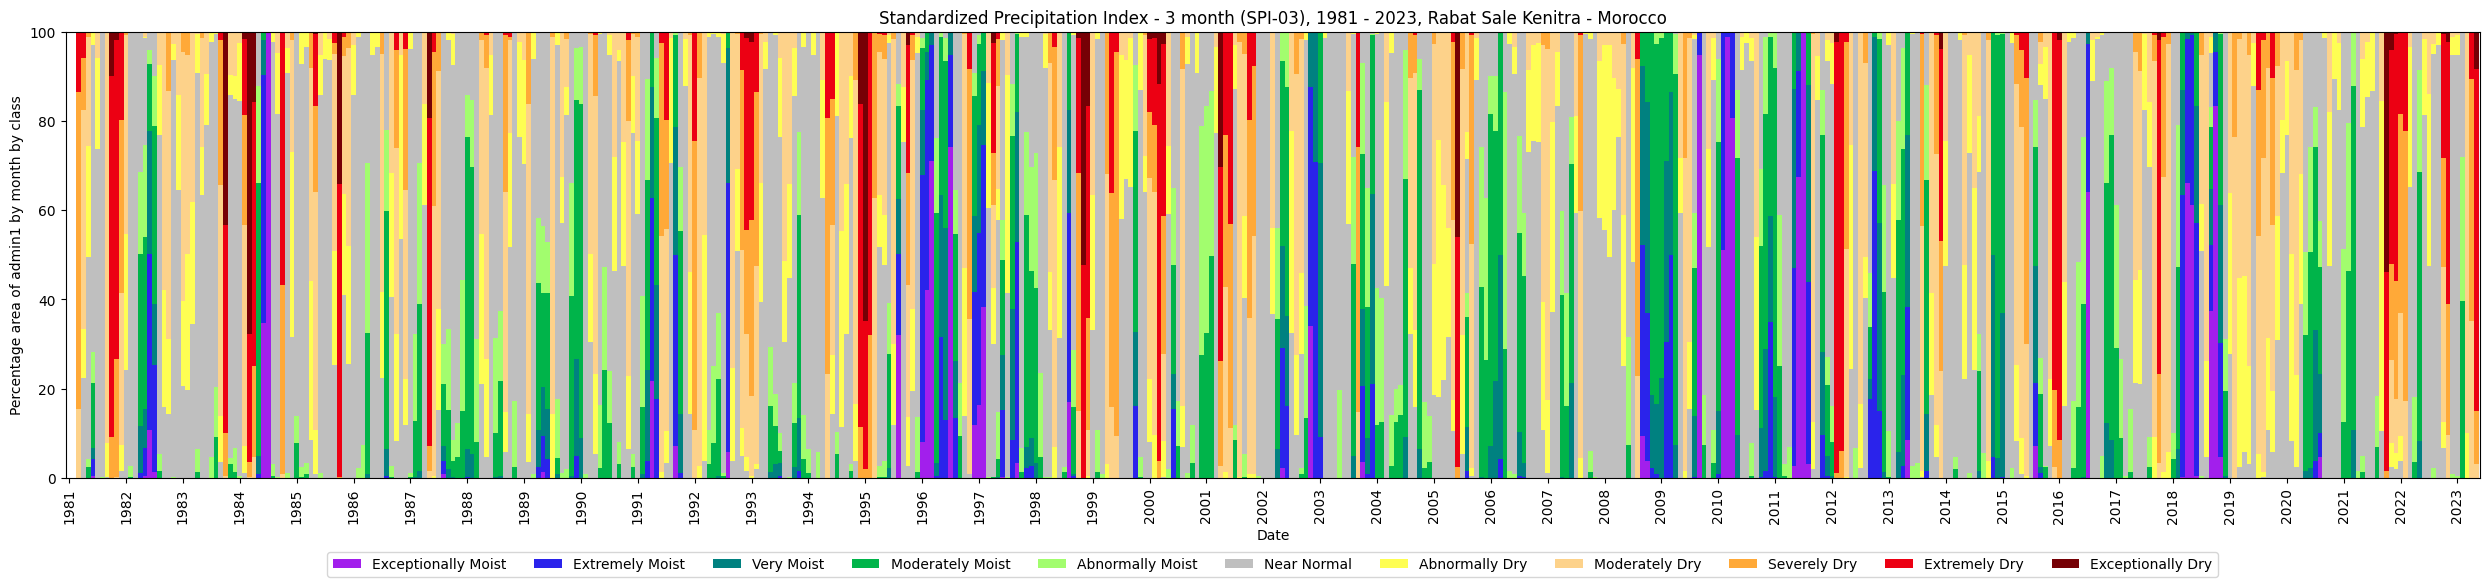

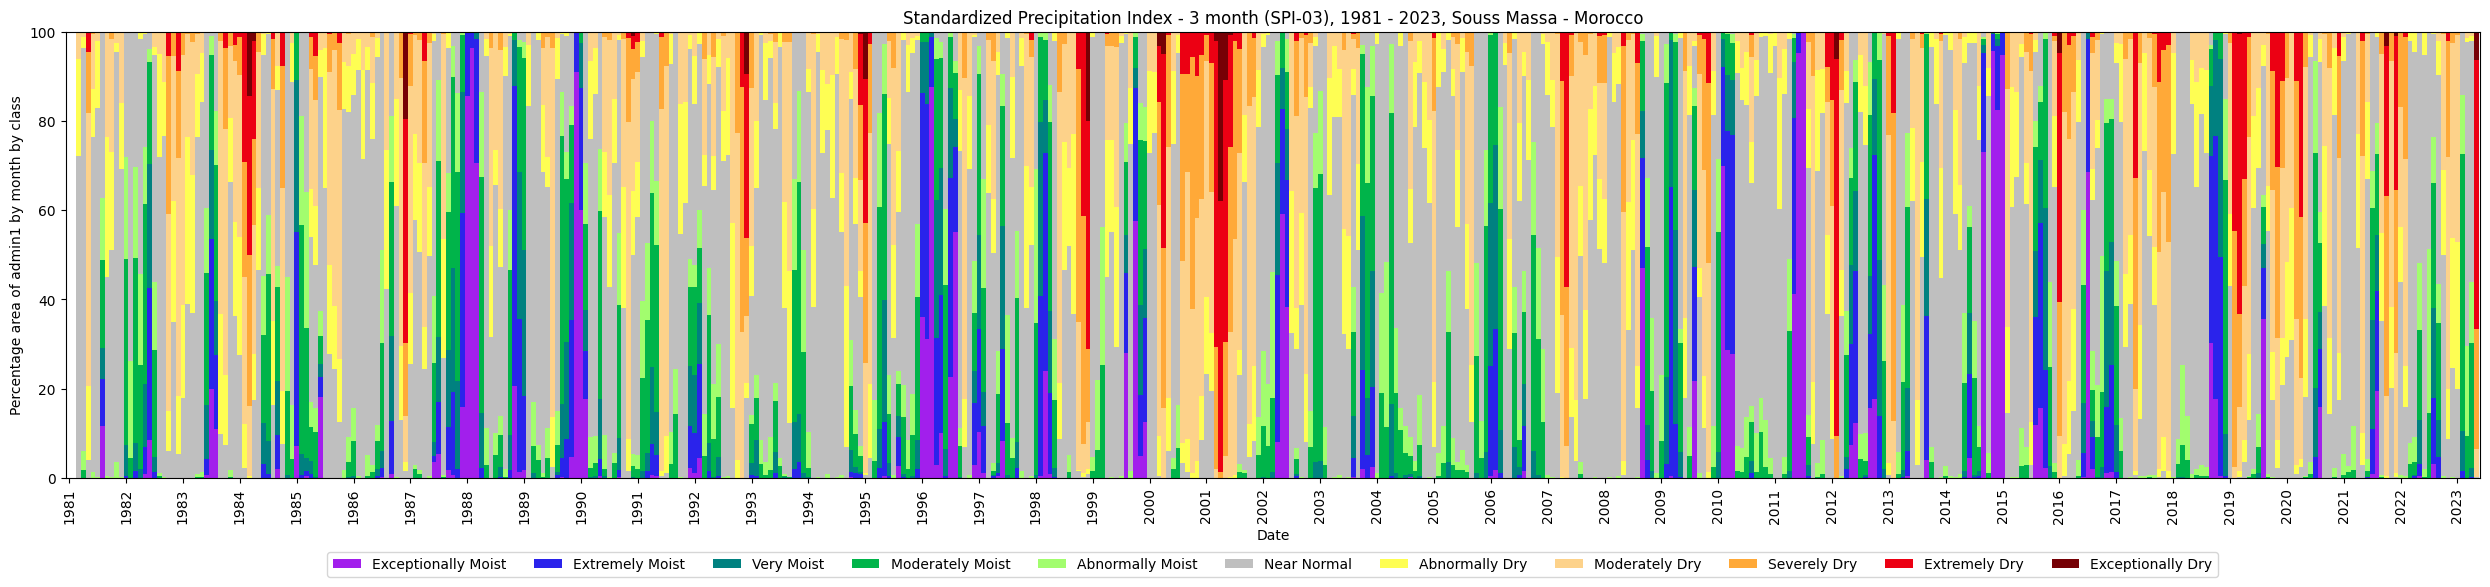

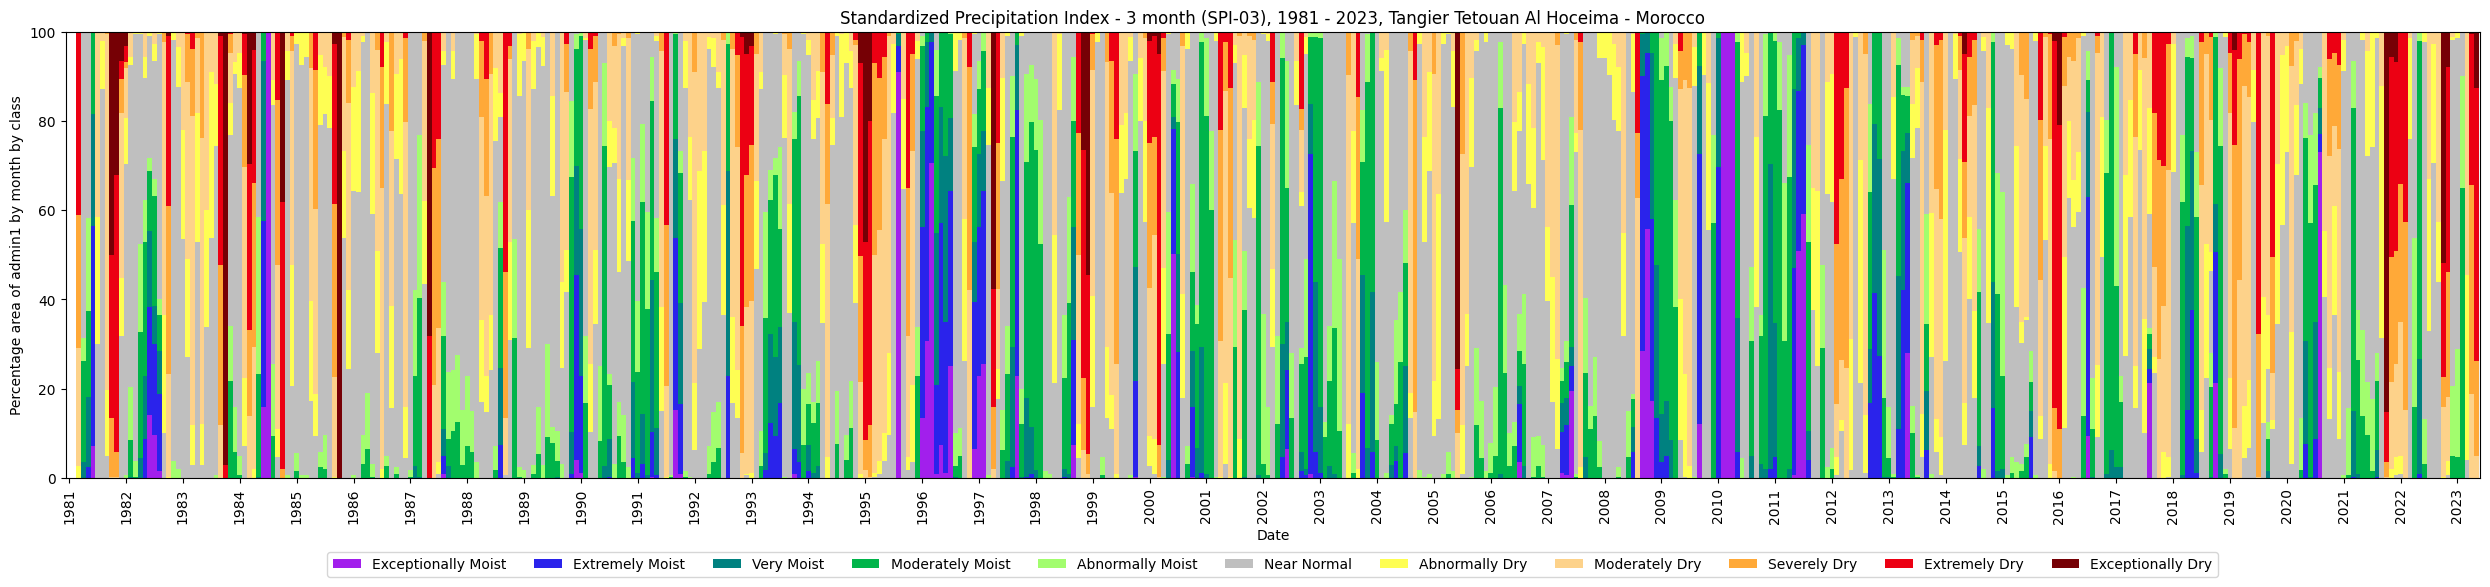

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file
data = pd.read_csv('../SPI/mar/08_tabular/mar_cli_spi03_spi_gamma_3_month.csv')

unique_countries = data['adm0_name'].unique()
if len(unique_countries) == 1:
    country_name = unique_countries[0]
else:
    raise ValueError("The dataset contains data for multiple countries.")

# Extract unique adm1_name values
unique_adm1 = data['adm1_name'].unique()

for adm1 in unique_adm1:
    adm1_data = data[(data['adm0_name'] == country_name) & (data['adm1_name'] == adm1)]

    # Define the classification bins and labels
    bins = [-float('inf'), -2.00, -1.50, -1.20, -0.70, -0.50, 0.50, 0.70, 1.20, 1.50, 2.00, float('inf')]
    labels = ['Exceptionally Dry', 'Extremely Dry', 'Severely Dry', 'Moderately Dry', 'Abnormally Dry', 'Near Normal', 'Abnormally Moist', 'Moderately Moist', 'Very Moist', 'Extremely Moist', 'Exceptionally Moist']
    colors = ['#760005', '#ec0013', '#ffa938', '#fdd28a', '#fefe53', '#bfbfbf', '#a2fd6e', '#00b44a', '#008180', '#2a23eb', '#a21fec']

    # Melt dataframe for the SPI columns into long format
    spi_data = adm1_data.melt(id_vars=['adm0_name'], value_vars=[col for col in adm1_data.columns if col.startswith('19') or col.startswith('20')], var_name='Date', value_name='SPI')

    # Drop rows with NaN values
    spi_data.dropna(inplace=True)

    # Classify the SPI values
    spi_data['Classification'] = pd.cut(spi_data['SPI'], bins=bins, labels=labels)

    # Group by Date and Classification and count
    grouped = spi_data.groupby(['Date', 'Classification']).size().unstack().fillna(0)

    # Convert counts to percentages
    grouped_percentage = grouped.divide(grouped.sum(axis=1), axis=0) * 100

    # Add missing months for the starting year
    start_year = int(grouped_percentage.index[0][:4])
    months_missing = int(grouped_percentage.index[0][4:6]) - 1

    for i in range(months_missing, 0, -1):
        new_index = f"{start_year}{i:02}01"
        grouped_percentage.loc[new_index] = [0]*len(labels)

    grouped_percentage.sort_index(inplace=True)

    # Reverse the order of colors, bins, and labels for the desired order in the stacked chart
    colors = colors[::-1]
    bins = bins[::-1]
    labels = labels[::-1]
    grouped_percentage = grouped_percentage[labels]

    # Create a stacked bar chart with increased figure width and bar width
    fig, ax = plt.subplots(figsize=(25, 6))
    grouped_percentage.plot(kind='bar', stacked=True, color=colors, width=1.0, ax=ax)

    # Set x-ticks at the start of each year
    yearly_ticks = [str(year) + '0101' for year in range(start_year, int(grouped_percentage.index[-1][:4]) + 1)]
    ax.set_xticks([grouped_percentage.index.get_loc(tick) for tick in yearly_ticks])
    ax.set_xticklabels([tick[:4] for tick in yearly_ticks])

    # Set the y-axis limits
    ax.set_ylim(0, 100)

    # Plot configuration
    plt.xlabel('Date')
    plt.ylabel('Percentage area of admin1 by month by class')

    # Change this line to use both adm1 and country_name
    plt.title(f'Standardized Precipitation Index - 3 month (SPI-03), 1981 - 2023, {adm1} - {country_name}')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(labels), fontsize='medium')
    plt.tight_layout()

    # Remove the space in the admin name, to make sure the image output filename doesn't have space too
    filename_adm1 = adm1.replace(" ", "")
    filename_country = country_name.replace(" ", "")

    plt.savefig(f"../SPI/mar/10_images/charts/spi_3_month_{filename_country}_{filename_adm1}.png", bbox_inches="tight", dpi=300)

    # Preview the plot
    plt.show()


### Admin 2

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the data from the CSV file
data = pd.read_csv('../SPI/mar/08_tabular/mar_cli_spi03_spi_gamma_3_month.csv')

unique_countries = data['adm0_name'].unique()
if len(unique_countries) == 1:
    country_name = unique_countries[0]
else:
    raise ValueError("The dataset contains data for multiple countries.")

# Extract unique adm1_name values
unique_adm1 = data['adm1_name'].unique()

# Calculate total number of plots for the progress bar based on unique adm2_name values
total_plots = data['adm2_name'].nunique()

with tqdm(total=total_plots, desc="Generating Plots") as pbar:
    for adm1 in unique_adm1:
        adm1_data = data[data['adm1_name'] == adm1]
        
        # Extract unique adm2_name values for the current adm1
        unique_adm2 = adm1_data['adm2_name'].unique()

        for adm2 in unique_adm2:
            adm2_data = adm1_data[adm1_data['adm2_name'] == adm2]

            # Define the classification bins and labels
            bins = [-float('inf'), -2.00, -1.50, -1.20, -0.70, -0.50, 0.50, 0.70, 1.20, 1.50, 2.00, float('inf')]
            labels = ['Exceptionally Dry', 'Extremely Dry', 'Severely Dry', 'Moderately Dry', 'Abnormally Dry', 'Near Normal', 'Abnormally Moist', 'Moderately Moist', 'Very Moist', 'Extremely Moist', 'Exceptionally Moist']
            colors = ['#760005', '#ec0013', '#ffa938', '#fdd28a', '#fefe53', '#bfbfbf', '#a2fd6e', '#00b44a', '#008180', '#2a23eb', '#a21fec']

            # Melt dataframe for the SPI columns into long format
            spi_data = adm2_data.melt(id_vars=['adm0_name'], value_vars=[col for col in adm2_data.columns if col.startswith('19') or col.startswith('20')], var_name='Date', value_name='SPI')

            # Drop rows with NaN values
            spi_data.dropna(inplace=True)

            # Classify the SPI values
            spi_data['Classification'] = pd.cut(spi_data['SPI'], bins=bins, labels=labels)

            # Group by Date and Classification and count
            grouped = spi_data.groupby(['Date', 'Classification']).size().unstack().fillna(0)

            # Convert counts to percentages
            grouped_percentage = grouped.divide(grouped.sum(axis=1), axis=0) * 100

            # Add missing months for the starting year
            start_year = int(grouped_percentage.index[0][:4])
            months_missing = int(grouped_percentage.index[0][4:6]) - 1

            for i in range(months_missing, 0, -1):
                new_index = f"{start_year}{i:02}01"
                grouped_percentage.loc[new_index] = [0]*len(labels)

            grouped_percentage.sort_index(inplace=True)

            # Reverse the order of colors, bins, and labels for the desired order in the stacked chart
            colors = colors[::-1]
            bins = bins[::-1]
            labels = labels[::-1]
            grouped_percentage = grouped_percentage[labels]

            # Create a stacked bar chart with increased figure width and bar width
            fig, ax = plt.subplots(figsize=(25, 6))
            grouped_percentage.plot(kind='bar', stacked=True, color=colors, width=1.0, ax=ax)

            # Set x-ticks at the start of each year
            yearly_ticks = [str(year) + '0101' for year in range(start_year, int(grouped_percentage.index[-1][:4]) + 1)]
            ax.set_xticks([grouped_percentage.index.get_loc(tick) for tick in yearly_ticks])
            ax.set_xticklabels([tick[:4] for tick in yearly_ticks])

            # Set the y-axis limits
            ax.set_ylim(0, 100)

            # Plot configuration
            plt.xlabel('Date')
            plt.ylabel('Percentage area of admin2 by month by class')
            
            # Change this line to use both adm1 and country_name
            plt.title(f'Standardized Precipitation Index - 3 month (SPI-03), 1981 - 2023, {adm2} - {adm1} - {country_name}')
            plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(labels), fontsize='medium')
            plt.tight_layout()

            # Adjust filename
            filename_adm2 = adm2.replace(" ", "")
            filename_adm1 = adm1.replace(" ", "")
            filename_country = country_name.replace(" ", "")

            plt.savefig(f"../SPI/mar/10_images/charts/spi_3_month_{filename_country}_{filename_adm1}_{filename_adm2}.png", bbox_inches="tight", dpi=300)
            
            # Close the plot to free up memory
            plt.close()

            # Update the progress bar
            pbar.update(1)


Generating Plots: 100%|████████████████████████████████████████████████| 69/69 [09:58<00:00,  8.67s/it]
